# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


Note that even with this small examination there are already several missing data items ('NaN') and some 'unknown' values (e.g. -1) in some of the records above.

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

This shows that though many of the features have one entry for each row (i.e., 891221 entries) there are also many cases where some of the features are not populated in every row. For example many features have 886367 entries, or 757897 is another common number of entries, and there are other commonly occurring numbers of entries per feature. The fact that these numbers re-occur across features suggests that there is a pattern where if one particular feature is missing in a row then it's likely that several other (probably related) features are also not populated. This is discussed further in [Step 1.1.3: Assess Missing Data in Each Row](#Step-1.1.3:-Assess-Missing-Data-in-Each-Row)

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


The feature info data is smaller than the demographic data set so it's best just to print this all out:

In [7]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

Create a dictionary pairing each attribute (as a key) to a list of strings that indicate empty data:

In [8]:
missing_data_codes = {}
for i in range(len(feat_info['attribute'])):
    missing_data_codes[feat_info['attribute'].iloc[i]] = feat_info['missing_or_unknown'].iloc[i].strip('[]').split(',')
    
missing_data_codes

{'AGER_TYP': ['-1', '0'],
 'ALTERSKATEGORIE_GROB': ['-1', '0', '9'],
 'ANREDE_KZ': ['-1', '0'],
 'CJT_GESAMTTYP': ['0'],
 'FINANZ_MINIMALIST': ['-1'],
 'FINANZ_SPARER': ['-1'],
 'FINANZ_VORSORGER': ['-1'],
 'FINANZ_ANLEGER': ['-1'],
 'FINANZ_UNAUFFAELLIGER': ['-1'],
 'FINANZ_HAUSBAUER': ['-1'],
 'FINANZTYP': ['-1'],
 'GEBURTSJAHR': ['0'],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': ['-1', '0'],
 'LP_LEBENSPHASE_FEIN': ['0'],
 'LP_LEBENSPHASE_GROB': ['0'],
 'LP_FAMILIE_FEIN': ['0'],
 'LP_FAMILIE_GROB': ['0'],
 'LP_STATUS_FEIN': ['0'],
 'LP_STATUS_GROB': ['0'],
 'NATIONALITAET_KZ': ['-1', '0'],
 'PRAEGENDE_JUGENDJAHRE': ['-1', '0'],
 'RETOURTYP_BK_S': ['0'],
 'SEMIO_SOZ': ['-1', '9'],
 'SEMIO_FAM': ['-1', '9'],
 'SEMIO_REL': ['-1', '9'],
 'SEMIO_MAT': ['-1', '9'],
 'SEMIO_VERT': ['-1', '9'],
 'SEMIO_LUST': ['-1', '9'],
 'SEMIO_ERL': ['-1', '9'],
 'SEMIO_KULT': ['-1', '9'],
 'SEMIO_RAT': ['-1', '9'],
 'SEMIO_KRIT': ['-1', '9'],
 'SEMIO_DOM': ['-1', '9'],
 'SEMIO_KA

The dictionary missing_data_codes now associates each feature to a list of *strings*. Where the strings are numbers, they need to be converted to integers:

In [9]:
for attr in missing_data_codes:
    for code in range(len(missing_data_codes[attr])):
        if isinstance(missing_data_codes[attr][code], str) and len(missing_data_codes[attr][code]) > 0:
            if missing_data_codes[attr][code][0].isdigit():
                missing_data_codes[attr][code] = int(missing_data_codes[attr][code][0])
            elif missing_data_codes[attr][code][0] == '-' and missing_data_codes[attr][code][1].isdigit():
                missing_data_codes[attr][code] = int(missing_data_codes[attr][code][1]) * -1

missing_data_codes

{'AGER_TYP': [-1, 0],
 'ALTERSKATEGORIE_GROB': [-1, 0, 9],
 'ANREDE_KZ': [-1, 0],
 'CJT_GESAMTTYP': [0],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_VORSORGER': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZTYP': [-1],
 'GEBURTSJAHR': [0],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': [-1, 0],
 'LP_LEBENSPHASE_FEIN': [0],
 'LP_LEBENSPHASE_GROB': [0],
 'LP_FAMILIE_FEIN': [0],
 'LP_FAMILIE_GROB': [0],
 'LP_STATUS_FEIN': [0],
 'LP_STATUS_GROB': [0],
 'NATIONALITAET_KZ': [-1, 0],
 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
 'RETOURTYP_BK_S': [0],
 'SEMIO_SOZ': [-1, 9],
 'SEMIO_FAM': [-1, 9],
 'SEMIO_REL': [-1, 9],
 'SEMIO_MAT': [-1, 9],
 'SEMIO_VERT': [-1, 9],
 'SEMIO_LUST': [-1, 9],
 'SEMIO_ERL': [-1, 9],
 'SEMIO_KULT': [-1, 9],
 'SEMIO_RAT': [-1, 9],
 'SEMIO_KRIT': [-1, 9],
 'SEMIO_DOM': [-1, 9],
 'SEMIO_KAEM': [-1, 9],
 'SEMIO_PFLICHT': [-1, 9],
 'SEMIO_TRADV': [-1, 9],
 'SHOPPER_TYP': [-1],
 'SOHO_KZ': [-

Now the number codes are integer values instead of strings. The strings which indicate missing data (empty string, 'X', 'XX') are still strings. This is now set up as we need it so we can now replace the misiing values with NaN:

In [10]:
for attr in missing_data_codes:
    azdias[attr].replace(to_replace=missing_data_codes[attr], value=np.nan, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# First count the number of NaN entries for each feature:
print("Number of empty values for each feature:")
for feat in azdias.columns.values:
    print("{0}: {1}".format(feat, azdias[feat].isnull().sum()))

Number of empty values for each feature:
AGER_TYP: 685843
ALTERSKATEGORIE_GROB: 2881
ANREDE_KZ: 0
CJT_GESAMTTYP: 4854
FINANZ_MINIMALIST: 0
FINANZ_SPARER: 0
FINANZ_VORSORGER: 0
FINANZ_ANLEGER: 0
FINANZ_UNAUFFAELLIGER: 0
FINANZ_HAUSBAUER: 0
FINANZTYP: 0
GEBURTSJAHR: 392318
GFK_URLAUBERTYP: 4854
GREEN_AVANTGARDE: 0
HEALTH_TYP: 111196
LP_LEBENSPHASE_FEIN: 97632
LP_LEBENSPHASE_GROB: 94572
LP_FAMILIE_FEIN: 77792
LP_FAMILIE_GROB: 77792
LP_STATUS_FEIN: 4854
LP_STATUS_GROB: 4854
NATIONALITAET_KZ: 108315
PRAEGENDE_JUGENDJAHRE: 108164
RETOURTYP_BK_S: 4854
SEMIO_SOZ: 0
SEMIO_FAM: 0
SEMIO_REL: 0
SEMIO_MAT: 0
SEMIO_VERT: 0
SEMIO_LUST: 0
SEMIO_ERL: 0
SEMIO_KULT: 0
SEMIO_RAT: 0
SEMIO_KRIT: 0
SEMIO_DOM: 0
SEMIO_KAEM: 0
SEMIO_PFLICHT: 0
SEMIO_TRADV: 0
SHOPPER_TYP: 111196
SOHO_KZ: 73499
TITEL_KZ: 889061
VERS_TYP: 111196
ZABEOTYP: 0
ALTER_HH: 310267
ANZ_PERSONEN: 73499
ANZ_TITEL: 73499
HH_EINKOMMEN_SCORE: 18348
KK_KUNDENTYP: 584612
W_KEIT_KIND_HH: 147988
WOHNDAUER_2008: 73499
ANZ_HAUSHALTE_AKTIV: 99611
AN

Create a data frame to store the count of missing values per category. Then plot a histogram showing the distribution of the number of missing data values across the features.

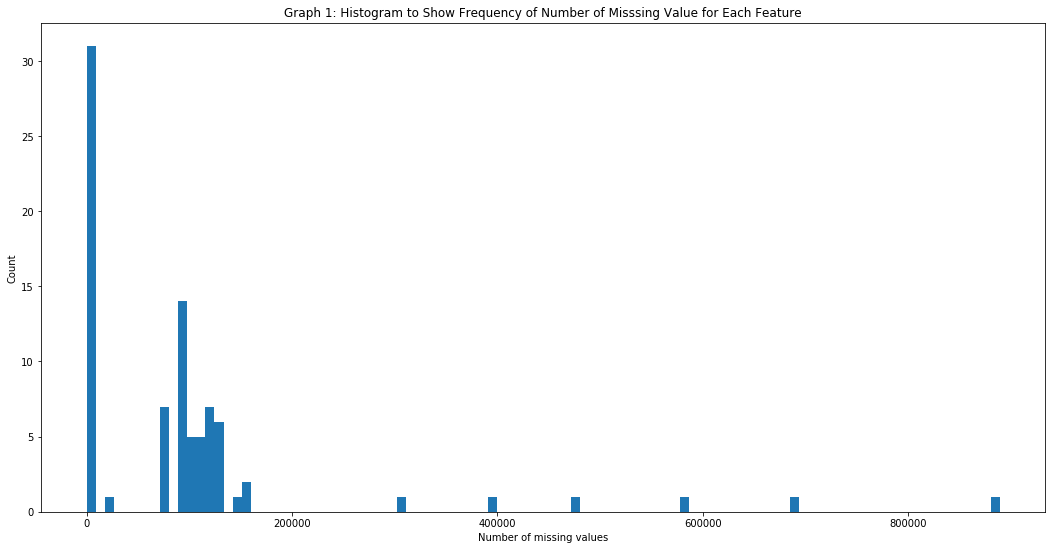

In [12]:
missing_data_count = pd.DataFrame({'Feature': [feature for feature in azdias.columns.values],
                            'Count': [azdias[feature].isnull().sum() for feature in azdias.columns.values]})
missing_data_count.set_index("Feature", drop=True, inplace=True)
plt.figure(figsize=(18, 9))
plt.hist(missing_data_count['Count'], bins=100)
plt.xlabel('Number of missing values')
plt.ylabel('Count')
plt.title('Graph 1: Histogram to Show Frequency of Number of Misssing Value for Each Feature')
plt.show()

It's clear from the Graph 1 that the largest frequency is at 0 missing values. There is a cluster of frequencies roughly following a normal distribution centred around 120000 missing values per feature. There are 6 outlier features that have more than 250000 missing values each. We can identify these:

In [13]:
outliers = [missing_data_count.index[feature] for feature in range(len(missing_data_count.index)) if missing_data_count['Count'].iloc[feature] > 250000]
outliers

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

These will be removed from the data in a forthcoming step. Three of these (AGER_TYP, GEBURTSJAHR, ALTER_HH) are related to age, so it's quite likely that if one is missing then the other two will be missing too.

In [14]:
# Investigate patterns in the amount of missing data in each column.

To do this, create a new data frame containing only the features where at least some of the values are missing:

In [15]:
missing_data_above_zero = missing_data_count
for feature in missing_data_above_zero.index:
    if missing_data_above_zero['Count'].loc[feature] == 0:
        missing_data_above_zero.drop(feature, inplace=True)

missing_data_above_zero

,Count
Feature,
AGER_TYP,685843
ALTERSKATEGORIE_GROB,2881
CJT_GESAMTTYP,4854
GEBURTSJAHR,392318
GFK_URLAUBERTYP,4854
HEALTH_TYP,111196
LP_LEBENSPHASE_FEIN,97632
LP_LEBENSPHASE_GROB,94572
LP_FAMILIE_FEIN,77792


Create a bar chart of the amount of missing data in each column:

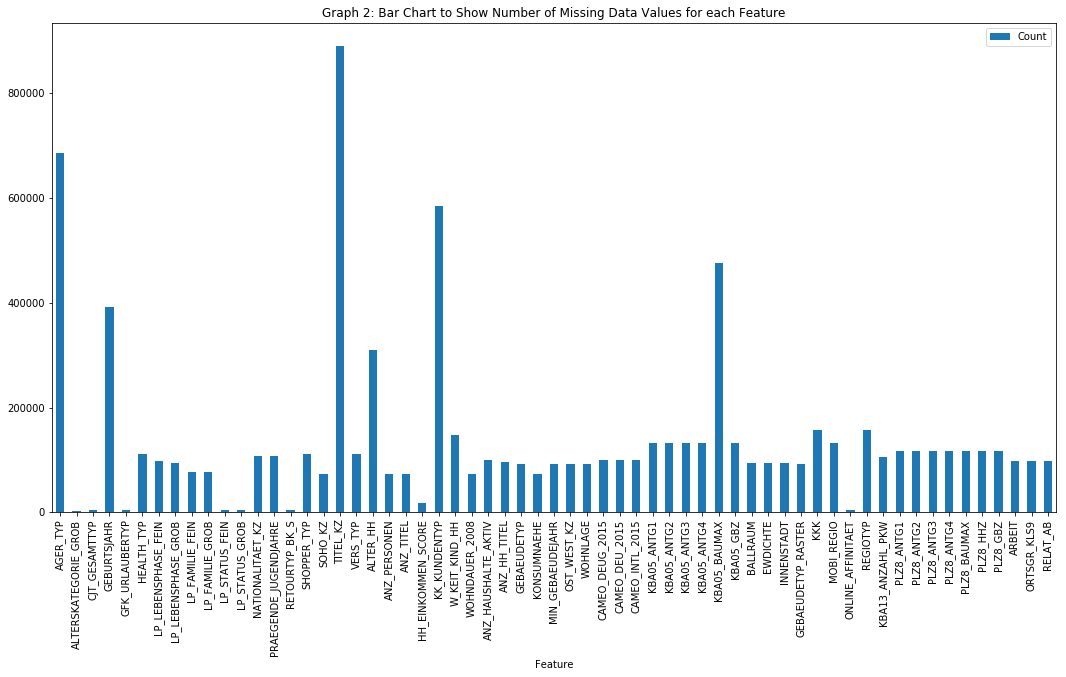

In [16]:
missing_data_above_zero.plot.bar(figsize=(18, 9), title='Graph 2: Bar Chart to Show Number of Missing Data Values for each Feature')
plt.show()

Now change the y axis to focus in on the counts below 180000:

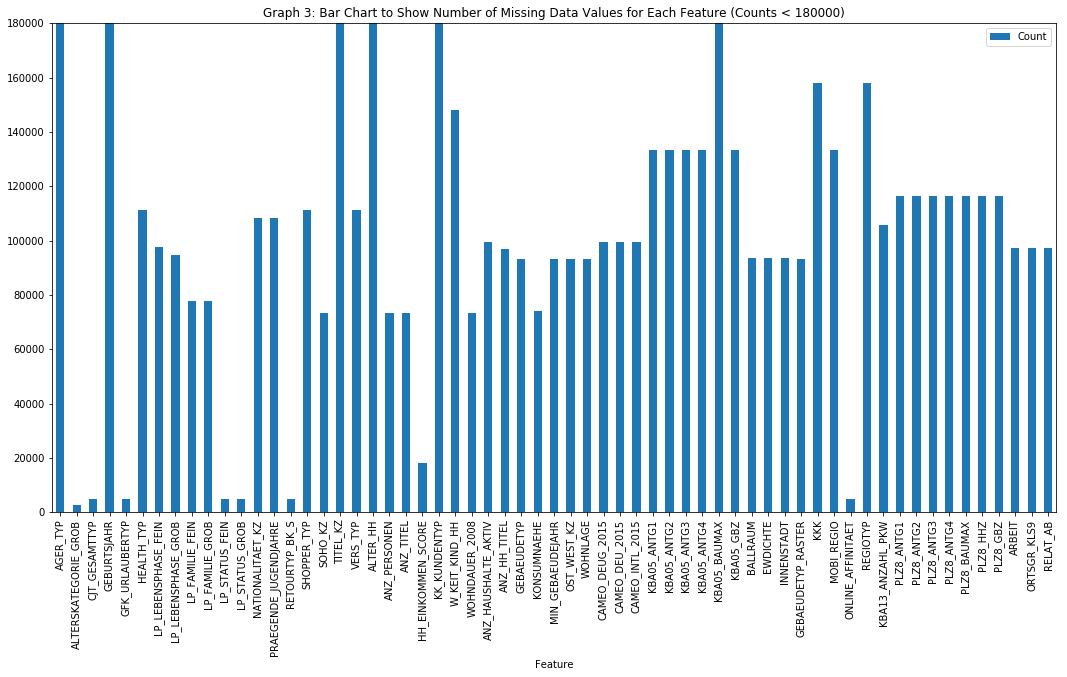

In [17]:
missing_data_above_zero.plot.bar(figsize=(18, 9), ylim=(0, 180000), title='Graph 3: Bar Chart to Show Number of Missing Data Values for Each Feature (Counts < 180000)')
plt.show()

This shows that several of the features have the same number of missing values.  For example: PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3 and PLZ8_ANTG4 (and others). These features are all related to the number of houses or buildings so it is unsurprising that they are related. It's possible that if this data is missing for one of these features in a record then it is also missing for all of these related features in the same record. This looks like a clear pattern in the data.

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
for feature in azdias.columns.values:
    if feature in outliers:
        azdias.drop(feature, axis=1, inplace=True)

In [19]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


The six outlier columns have been removed.

#### Discussion 1.1.2: Assess Missing Data in Each Column

***Report your observations regarding the amount of missing data in each column.***
Graph 1 shows that the largest frequency is at 0 missing values. There is a cluster of frequencies roughly following a normal distribution centred around 120000 missing values per feature. There are 6 outlier features that have more than 250000 missing values each.

***Are there any patterns in missing values?***
Graph 3 shows that several of the features have the same number of missing values.  For example: PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3 and PLZ8_ANTG4 (and others). These features are all related to the number of houses or buildings so it is unsurprising that they are related. It's possible that if this data is missing for one of these features in a record then it is also missing for all of these related features in the same record. This looks like a pattern in the data.

***Which columns were removed from the dataset?***

The removed columns were the ones given in list outliers:

In [20]:
outliers

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

#### Step 1.1.3: Assess Missing Data in Each Row
Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?
missing_data_per_row = [azdias.iloc[i].isnull().sum() for i in range(len(azdias.index))]

Now create a histogram of this data to show the distribution:

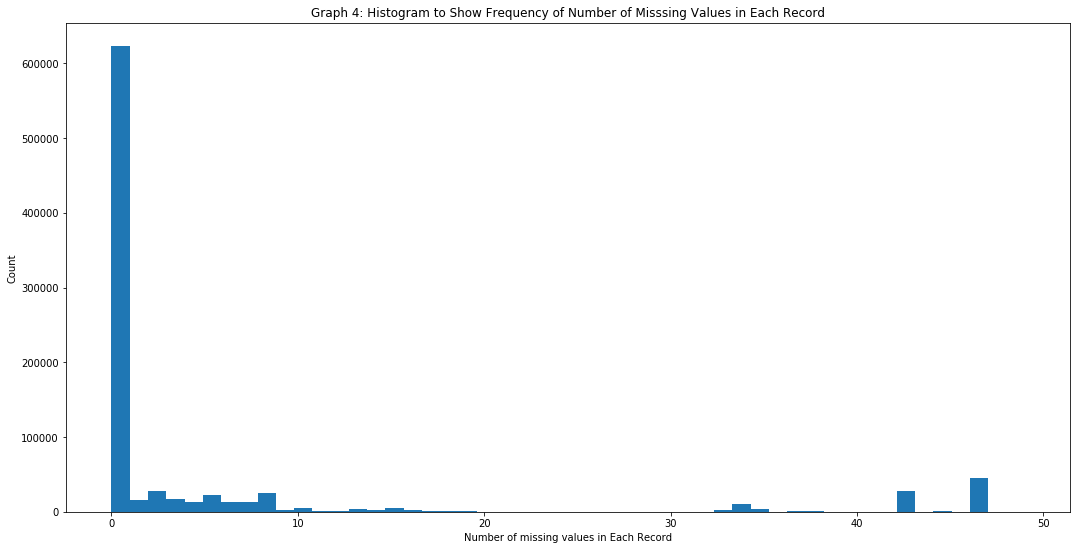

In [22]:
plt.figure(figsize=(18, 9))
plt.hist(missing_data_per_row, bins=50)
plt.xlabel('Number of missing values in Each Record')
plt.ylabel('Count')
plt.title('Graph 4: Histogram to Show Frequency of Number of Misssing Values in Each Record')
plt.show()

Graph 4 shows that for records that have any missing values then the number of missing values per record commonly seems to be either below 20 (especially below 10) or between about 33 and 47. A reasonable choice for a cutoff point for the two groups of rows could be 30, i.e. records with <=30 missing values and records with >30 missing values.

In [23]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

Append a new column to the azdias dataframe indicating if the row >30 missing values or <=30 missing values. Start by creating list of boolean data:

In [24]:
high_missing_data = [missing_data_per_row[i]>30 for i in range(len(missing_data_per_row))]

Now add this as a new column in the azdias dataframe:

In [25]:
azdias['high_missing_data'] = high_missing_data

Now split the data according to whether the amount of missing data is >30 ("True") or <=30 ("False"):

In [26]:
grouped = azdias.groupby('high_missing_data')

In [27]:
azdias_low_missing_data = grouped.get_group(False)
azdias_low_missing_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,high_missing_data
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,False
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,False
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,False
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,False
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,False


In [28]:
azdias_low_missing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798067 entries, 1 to 891220
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     795264 non-null float64
ANREDE_KZ                798067 non-null int64
CJT_GESAMTTYP            793318 non-null float64
FINANZ_MINIMALIST        798067 non-null int64
FINANZ_SPARER            798067 non-null int64
FINANZ_VORSORGER         798067 non-null int64
FINANZ_ANLEGER           798067 non-null int64
FINANZ_UNAUFFAELLIGER    798067 non-null int64
FINANZ_HAUSBAUER         798067 non-null int64
FINANZTYP                798067 non-null int64
GFK_URLAUBERTYP          793318 non-null float64
GREEN_AVANTGARDE         798067 non-null int64
HEALTH_TYP               761341 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750721 non-null float64
LP_FAMILIE_FEIN          766593 non-null float64
LP_FAMILIE_GROB          766593 non-null float64
LP_STATUS_FEIN           793318 non-null float64
LP_STATUS_GROB           

In [29]:
azdias_high_missing_data = grouped.get_group(True)
azdias_high_missing_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,high_missing_data
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [30]:
azdias_high_missing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93154 entries, 0 to 891187
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     93076 non-null float64
ANREDE_KZ                93154 non-null int64
CJT_GESAMTTYP            93049 non-null float64
FINANZ_MINIMALIST        93154 non-null int64
FINANZ_SPARER            93154 non-null int64
FINANZ_VORSORGER         93154 non-null int64
FINANZ_ANLEGER           93154 non-null int64
FINANZ_UNAUFFAELLIGER    93154 non-null int64
FINANZ_HAUSBAUER         93154 non-null int64
FINANZTYP                93154 non-null int64
GFK_URLAUBERTYP          93049 non-null float64
GREEN_AVANTGARDE         93154 non-null int64
HEALTH_TYP               18684 non-null float64
LP_LEBENSPHASE_FEIN      45761 non-null float64
LP_LEBENSPHASE_GROB      45928 non-null float64
LP_FAMILIE_FEIN          46836 non-null float64
LP_FAMILIE_GROB          46836 non-null float64
LP_STATUS_FEIN           93049 non-null float64
LP_STATUS_GROB           93049 non-null floa

The two new data sets look as we would expect (i.e. correct number of total entries, etc.)

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

Referring to Graph 3 above, there are 8 features where there is clearly very little missing data. These are:

In [32]:
fully_populated_features = ['ALTERSKATEGORIE_GROB', 
                            'CJT_GESAMTTYP', 
                            'GFK_URLAUBERTYP', 
                            'LP_STATUS_FEIN', 
                            'LP_STATUS_GROB', 
                            'RETOURTYP_BK_S', 
                            'HH_EINKOMMEN_SCORE', 
                            'ONLINE_AFFINITAET']

Define a function to perform the comparison of the distribution of each of these features in the 'high missing data' and 'low missing data' sets:

In [33]:
def compare_feature_distribution(feature, feat_num):
    fig, ax = plt.subplots(1,2, figsize=[18,9])
    ax[0].set_title('Low Missing Data Per Row')
    ax[1].set_title('High Missing Data Per Row')
    fig.suptitle('Graph {0} - Comparing Distribution of {1} in Rows with Low and High Missing Data Levels'.format(5 + feat_num, feature))
    sns.countplot(x=feature, data=azdias_low_missing_data, ax=ax[0])
    sns.countplot(x=feature, data=azdias_high_missing_data, ax=ax[1])

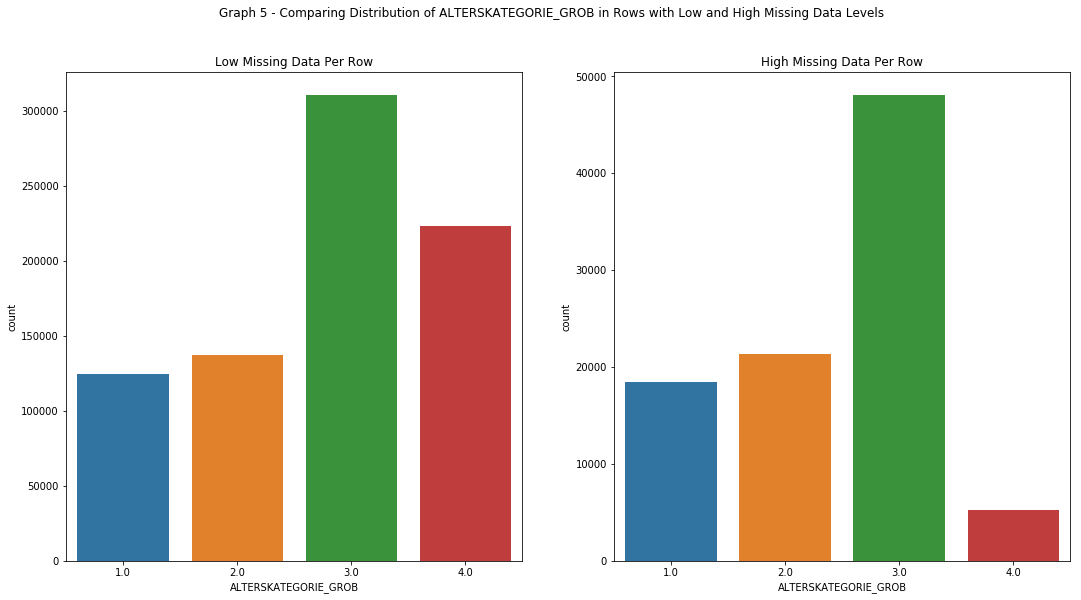

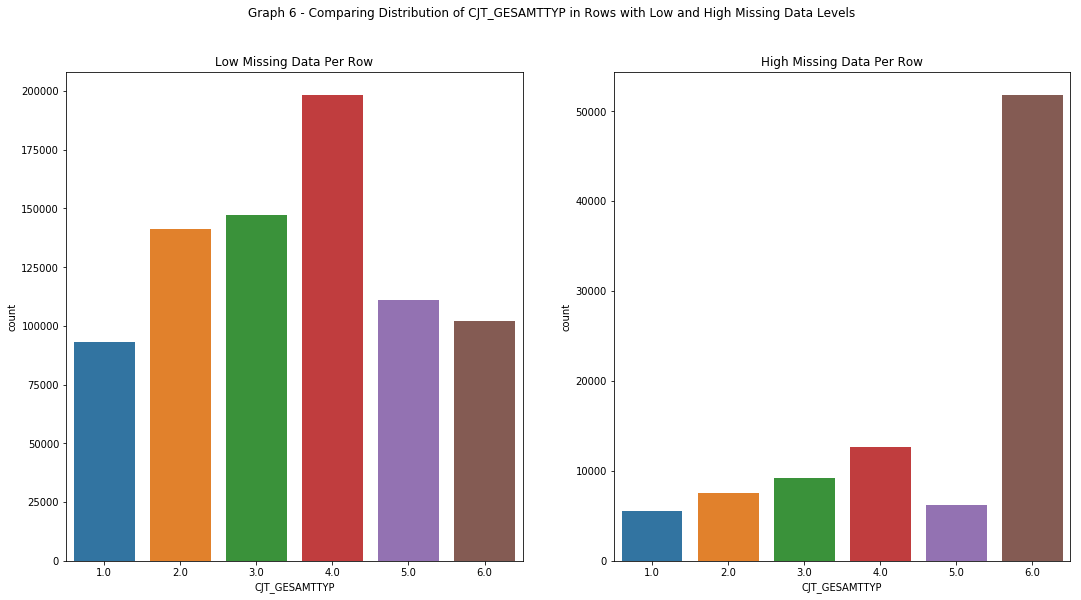

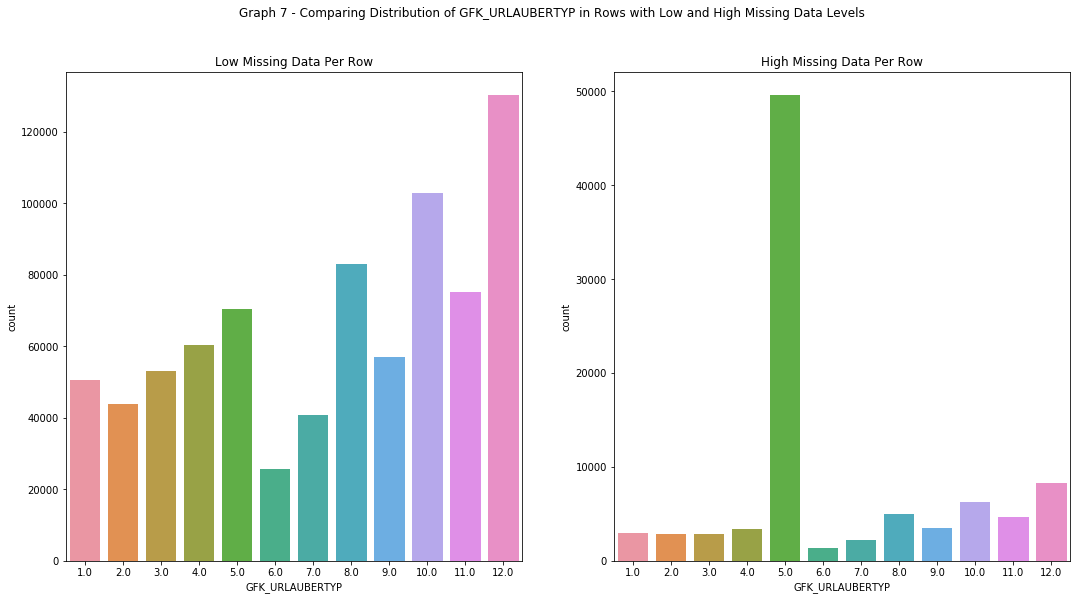

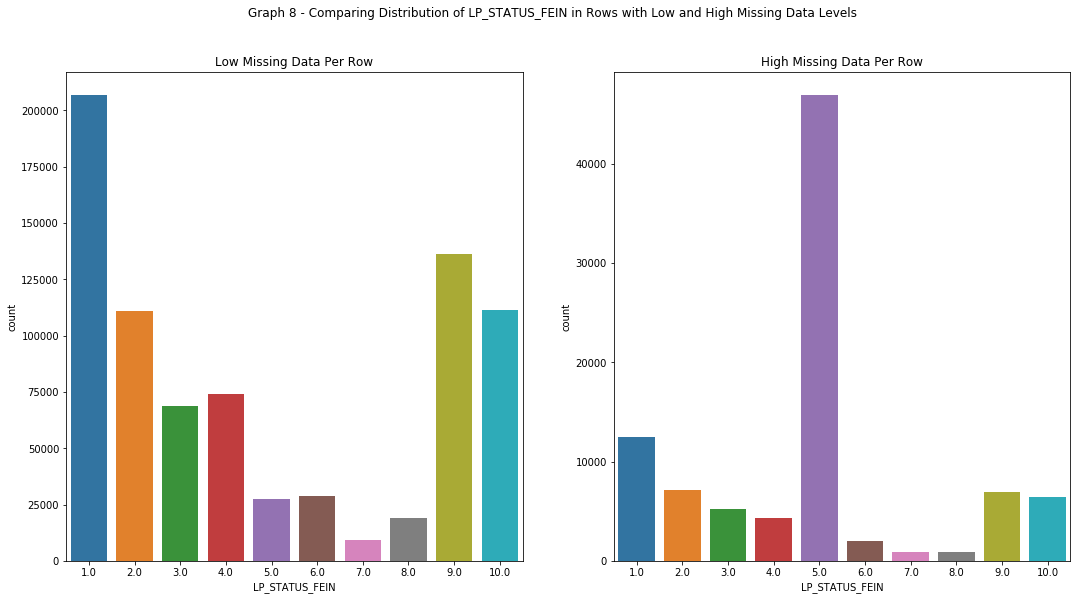

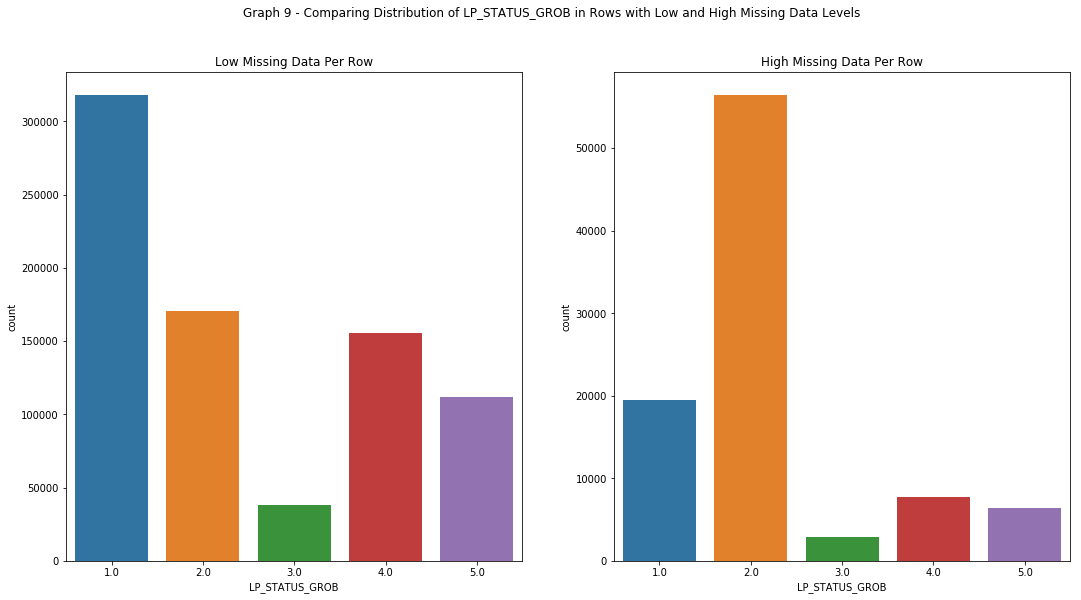

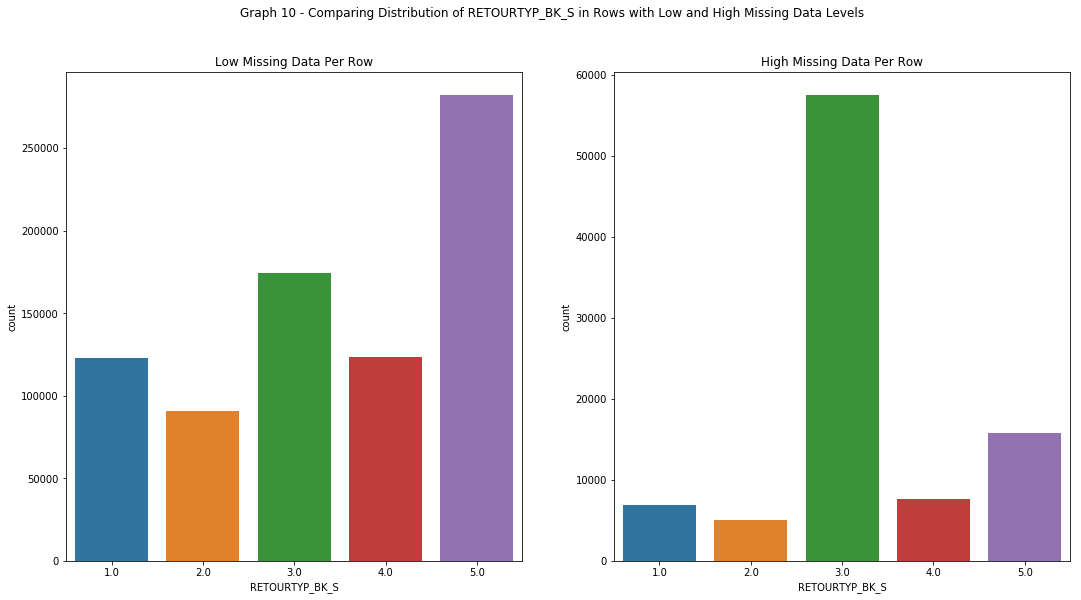

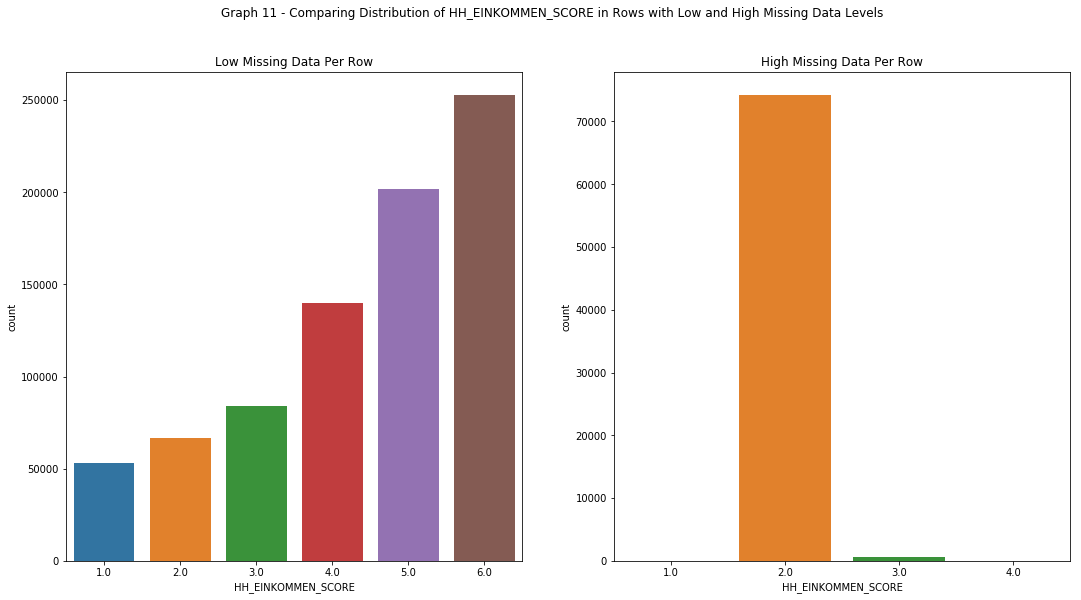

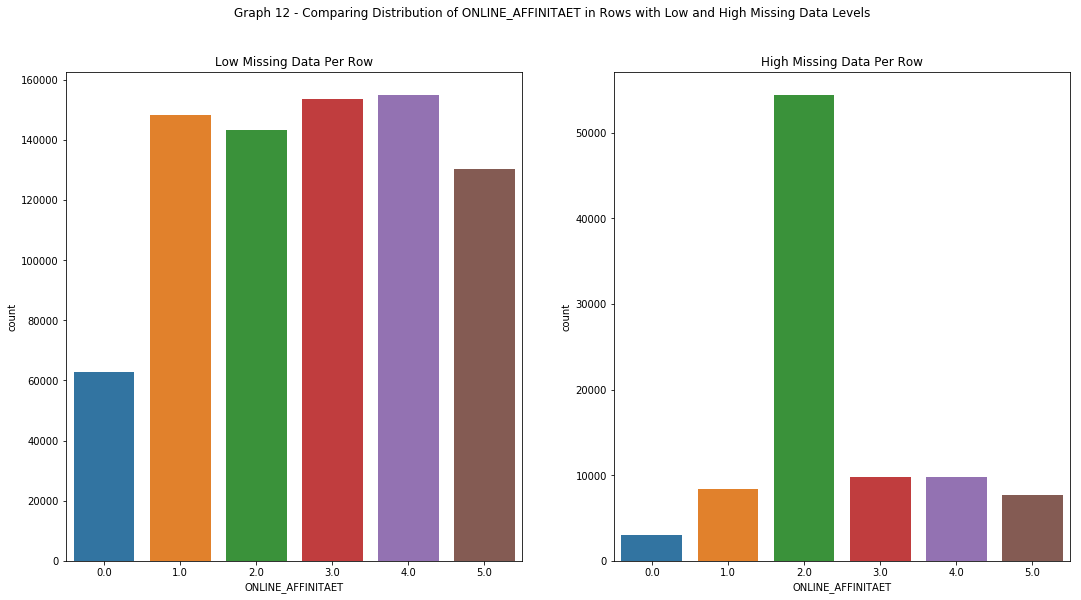

In [34]:
for i, feature in enumerate(fully_populated_features):
    compare_feature_distribution(feature, i)

#### Discussion 1.1.3: Assess Missing Data in Each Row

It's clear from Graphs 5-12 that the distribution of values for the well-populated features is very different between the entries with a small amount of missing data and entries with a large amount of missing data. These will need to be treated as special cases later in the analysis.

Since the instruction is to continue analysis with the low missing data set, now is a good time to create  separate data frame for this, drop the 'high_missing_data' column, and reset the index so that rows indices are contiguous:

In [35]:
azdias_cleaned = azdias_low_missing_data.drop(columns='high_missing_data')
azdias_cleaned.reset_index(drop=True, inplace=True)
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798067 entries, 0 to 798066
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     795264 non-null float64
ANREDE_KZ                798067 non-null int64
CJT_GESAMTTYP            793318 non-null float64
FINANZ_MINIMALIST        798067 non-null int64
FINANZ_SPARER            798067 non-null int64
FINANZ_VORSORGER         798067 non-null int64
FINANZ_ANLEGER           798067 non-null int64
FINANZ_UNAUFFAELLIGER    798067 non-null int64
FINANZ_HAUSBAUER         798067 non-null int64
FINANZTYP                798067 non-null int64
GFK_URLAUBERTYP          793318 non-null float64
GREEN_AVANTGARDE         798067 non-null int64
HEALTH_TYP               761341 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750721 non-null float64
LP_FAMILIE_FEIN          766593 non-null float64
LP_FAMILIE_GROB          766593 non-null float64
LP_STATUS_FEIN           793318 non-null float64
LP_STATUS_GROB           

In [36]:
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [37]:
# How many features are there of each data type?

# Create the selected_feat_info data set by removing the outlier features:
selected_feat_info = feat_info
selected_feat_info.set_index("attribute", drop=True, inplace=True)
for feature in feat_info.index:
    if feature in outliers:
        selected_feat_info.drop(feature, axis=0, inplace=True)
        
# Now group selected features by type and count how many there are of each type:
grouped_features = selected_feat_info.groupby('type')
print("Number of categorical features: {}".format(len(grouped_features.get_group('categorical'))))
print("Number of ordinal features: {}".format(len(grouped_features.get_group('ordinal'))))
print("Number of numeric features: {}".format(len(grouped_features.get_group('numeric'))))
print("Number of mixed features: {}".format(len(grouped_features.get_group('mixed'))))

Number of categorical features: 18
Number of ordinal features: 49
Number of numeric features: 6
Number of mixed features: 6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [38]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Examine the categorical group:
for index in grouped_features.get_group('categorical').index:
    print("Unique values in {0}: {1}".format(index, azdias[index].unique()))

Unique values in ANREDE_KZ: [1 2]
Unique values in CJT_GESAMTTYP: [ 2.  5.  3.  4.  1.  6. nan]
Unique values in FINANZTYP: [4 1 6 5 2 3]
Unique values in GFK_URLAUBERTYP: [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
Unique values in GREEN_AVANTGARDE: [0 1]
Unique values in LP_FAMILIE_FEIN: [ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]
Unique values in LP_FAMILIE_GROB: [ 2.  3.  1. nan  5.  4.]
Unique values in LP_STATUS_FEIN: [ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]
Unique values in LP_STATUS_GROB: [ 1.  2.  4.  5.  3. nan]
Unique values in NATIONALITAET_KZ: [nan  1.  3.  2.]
Unique values in SHOPPER_TYP: [nan  3.  2.  1.  0.]
Unique values in SOHO_KZ: [nan  1.  0.]
Unique values in VERS_TYP: [nan  2.  1.]
Unique values in ZABEOTYP: [3 5 4 1 6 2]
Unique values in GEBAEUDETYP: [nan  8.  1.  3.  2.  6.  4.  5.]
Unique values in OST_WEST_KZ: [nan 'W' 'O']
Unique values in CAMEO_DEUG_2015: [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
Unique values in CAMEO_DEU_2015: [nan '8

The binary value that can take non-numeric values is OST_WEST_KZ (can take value 'W' or 'O'). Let's re-encode these as 'O' = 0 and 'W' = 1:

In [39]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_cleaned['OST_WEST_KZ'].replace(to_replace='O', value=0, inplace=True)
azdias_cleaned['OST_WEST_KZ'].replace(to_replace='W', value=1, inplace=True)

The features with a large amount of missing data have already been dropped so it's safe to say that none of the remaining categorical features can be dropped on that basis.

The other consideration is the number of categories for each feature. Each category will add a new dimension to the dataset. This can lead to "the curse of dimensionality" which could cause the clustering analysis to fail, so it is preferable to add as few new features as possible. Nevertheless, we will be doing principal component analysis and using the results to reduce the dimensionality later on, so it's ok to add some new features.

Note that several of the features have overlapping data. Specifically:

- CAMEO_DEU_2015 is the detailed expression of CAMEO_DEUG_2015
- LP_FAMILIE_FEIN is the detailed expression of LP_FAMILIE_GROB
- LP_STATUS_FEIN is the detailed expression of LP_STATUS_GROB

Since they overlap, there is no point keeping both - it just adds extra dimensions and that can introduce dimensionality problems as already mentioned. There is a trade-off between keeping the more detailed versus less detailed versions of the features. Specifically, the advantage of keeping the detailed feature is that it minimises data loss. The disadvantage is that the detailed features have more possible values, so keeping them will introduce more new dimensions than keeping the less detailed features. In this analysis, the number of features is alraedy large, so the strategy will be to reduce the number of dimensions wherever possible. Therefore, CAMEO_DEU_2015, LP_FAMILIE_FEIN and LP_STATUS_FEIN will be dropped. The less detailed versions of these features will be retained. This is a good strategy for a "first pass" analysis where it is useful to get a general indication of the clustering results and draw initial conclusions. Such an analysis could be used to guide future work that would perhaps consider the more detailed features, if that was considered necessary.

In [40]:
overlap_feats_drop = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
azdias_cleaned.drop(columns=overlap_feats_drop, inplace=True)

This leaves 10 categorical features to be one-hot encoded.

Define the features to be one-hot encoded:

In [41]:
to_one_hot_encode = ['CJT_GESAMTTYP', 
                     'FINANZTYP', 
                     'GFK_URLAUBERTYP', 
                     'LP_FAMILIE_GROB', 
                     'LP_STATUS_GROB',
                     'NATIONALITAET_KZ', 
                     'SHOPPER_TYP',
                    'ZABEOTYP', 
                    'GEBAEUDETYP',
                    'CAMEO_DEUG_2015']

for feature in to_one_hot_encode:
    print("Unique values in {0}: {1}".format(feature, azdias_cleaned[feature].unique()))

Unique values in CJT_GESAMTTYP: [ 5.  3.  2.  4.  1.  6. nan]
Unique values in FINANZTYP: [1 6 5 2 4 3]
Unique values in GFK_URLAUBERTYP: [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
Unique values in LP_FAMILIE_GROB: [ 3.  1. nan  5.  2.  4.]
Unique values in LP_STATUS_GROB: [ 1.  2.  4.  5.  3. nan]
Unique values in NATIONALITAET_KZ: [ 1.  3.  2. nan]
Unique values in SHOPPER_TYP: [ 3.  2.  1.  0. nan]
Unique values in ZABEOTYP: [5 3 4 1 6 2]
Unique values in GEBAEUDETYP: [8. 1. 3. 2. 6. 4. 5.]
Unique values in CAMEO_DEUG_2015: ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']


Note that for all but one of these features, every possible value (where a value is known, i.e. not NaN) is represented in the data set. The exception is GEBAEUDETYP. Value 7 is not represented in the data set. It is possible that the customer data set will contain this value, but the get_dummies function will not make a feature for this value automatically because it is missing here. Therefore, it is necessary to add the feature GEBAEUDETYP_7.0 manually as a feature in the data frame. This will be a column entirely consisting of zeros. This will be done after the one-hot encoding. The cleaning function (to be written later) will also need to account for the possibility of missing categories and add them manually (as a column of zeros) if needed.

Missing (NaN) values will cause get_dummies to either ignore the value (making no non-zero entry for any of the categories) or add an extra feature for NaN columns. Neither of these is useful in this analysis, so it is better to remove rows containing a NaN value in any of the one-hot encoded columns now.

In [42]:
# Remove rows where at least one of the one-hot encoded features has a missing (NaN) value.
for feature in to_one_hot_encode:
    missing_one_hot = list(azdias_cleaned[feature].isnull())
    remove_missing_index = [i for i in range(len(missing_one_hot)) if missing_one_hot[i]]
    azdias_cleaned.drop(index=remove_missing_index, inplace=True)
    azdias_cleaned.reset_index(drop=True, inplace=True)
    print("Dropped {0} rows due to missing data in feature {1}".format(len(remove_missing_index), feature))

Dropped 4749 rows due to missing data in feature CJT_GESAMTTYP
Dropped 0 rows due to missing data in feature FINANZTYP
Dropped 0 rows due to missing data in feature GFK_URLAUBERTYP
Dropped 26725 rows due to missing data in feature LP_FAMILIE_GROB
Dropped 0 rows due to missing data in feature LP_STATUS_GROB
Dropped 32397 rows due to missing data in feature NATIONALITAET_KZ
Dropped 2692 rows due to missing data in feature SHOPPER_TYP
Dropped 0 rows due to missing data in feature ZABEOTYP
Dropped 0 rows due to missing data in feature GEBAEUDETYP
Dropped 5668 rows due to missing data in feature CAMEO_DEUG_2015


One-hot encode:

In [43]:
azdias_cleaned = pd.get_dummies(azdias_cleaned, columns=to_one_hot_encode, prefix_sep='_')

In [44]:
# Insert the feature GEBAEUDETYP_7.0 which we already determined is missing:
azdias_cleaned.insert(loc=azdias_cleaned.columns.get_loc('GEBAEUDETYP_8.0'), column='GEBAEUDETYP_7.0', value=0)

Sanity check:

In [45]:
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725836 entries, 0 to 725835
Columns: 130 entries, ALTERSKATEGORIE_GROB to CAMEO_DEUG_2015_9
dtypes: float64(42), int64(24), object(1), uint8(63)
memory usage: 414.6+ MB


In [46]:
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
0,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,0,0,0,1,0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,0
2,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0
4,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,1,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features
**Re-encoded binary categoricals**

- OST_WEST_KZ was originally a non-numeric binary value categorical, so this had to be re-encoded as binary (1 or 0).

**Dropped Features**

Some features are dropped because they contain data that duplicates data in other features. The aim of dropping these is to limit the number of dimensions to a reasonable value and avoid "the curse of dimensonality". In all cases, we keep the less detailed versions of the features, and drop the detailed version. The rationale behind this decision is to minimise the number of added dimensions. This should result in a more stable clustering model and a simpler "first pass" analysis on the data.

The dropped fetures are:

- CAMEO_DEUG_2015
- LP_FAMILIE_FEIN
- LP_STATUS_FEIN

**Re-encoded multi-level categorical features**

The remaining multi-level categorical features were re-encoded using dummy variables. Rows where one or more of these features has a missing (NaN) value were removed. In addition, any one-hot encoded categories missing from the data set were manually added (GEBAEUDETYP_7.0 was the only one missing from the azdias data set). The list of categorical features that were one-hot encoded is:

In [47]:
to_one_hot_encode

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [48]:
# Print all mixed features
grouped_features.get_group('mixed')

,information_level,type,missing_or_unknown
attribute,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0]
LP_LEBENSPHASE_GROB,person,mixed,[0]
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
WOHNLAGE,building,mixed,[-1]
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [49]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print("Unique values in PRAEGENDE_JUGENDJAHRE: {}".format(azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].unique()))

Unique values in PRAEGENDE_JUGENDJAHRE: [14. 15.  8.  3. 10. 11.  5.  9.  6.  4. nan  2.  1. 12. 13.  7.]


Values 1-15 need to be encoded in two new variables representing decade and movement to be set from PRAEGENDE_JUGENDJAHRE as described in the Data Dictionary. Since movement is a binary categorical (avantgarde or mainstream) we can define this new feature 'MOVEMENT' as a binary taking value 0 (avantgarde) or 1 (mainstream).

In [50]:
mainstream_categories = [1, 3, 5, 8, 10, 12, 14]
movement = [int(azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].iloc[i] in mainstream_categories) for i in azdias_cleaned.index]

Decade can take one of 6 values indicating one of the decades: 40s, 50s, 60s, 70s, 80s, 90s. We will encode this as taking one of the values 1 to 6 (i.e., 1 representing decade=40s, and upwards in order to 6 representing decade=90s).

In [51]:
forties_categories = [1, 2]
fifties_categories = [3, 4]
sixties_categories = [5, 6, 7]
seventies_categories = [8, 9]
eighties_categories = [10, 11, 12, 13]
nineties_categories = [14, 15]
    
decade_categories = {1: forties_categories, 
                     2: fifties_categories, 
                     3: sixties_categories, 
                     4: seventies_categories, 
                     5: eighties_categories, 
                     6: nineties_categories}

decade = np.zeros(len(azdias_cleaned),)

for dec_val, cats in decade_categories.items():
    new_decade = [int(azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].iloc[i] in cats) * dec_val for i in azdias_cleaned.index]
    decade = decade + np.asarray(new_decade)
    
# Assign NaN values to missing data points in movement and decade lists
missing_data = azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].isnull()

for i in decade:
    if missing_data[i] == True:
        decade[i] = np.nan
        movement[i] = np.nan

# Append to the data frame
azdias_cleaned['MOVEMENT'] = movement
azdias_cleaned['DECADE'] = decade

In [52]:
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE
0,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,0,1,6.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,1,0,0,0,0,0,0,6.0
2,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,1,0,0,0,1,4.0
3,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1,0,1,2.0
4,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,1,0,0,0,0,0,1,5.0


In [53]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print("Unique values in CAMEO_INTL_2015: {}".format(azdias_cleaned['CAMEO_INTL_2015'].unique()))

Unique values in CAMEO_INTL_2015: ['51' '24' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '12' '25'
 '23' '31' '52' '35' '45' '44' '32']


In [54]:
# The first digit represents wealth. The second digit represents life stage. 
# Each of these can be encoded as ordinal variables and take the values 1 to 5.

wealth = []
life_stage = []

valid_data = azdias_cleaned['CAMEO_INTL_2015'].notnull()

for i in azdias_cleaned.index:
    if valid_data[i]:
        wealth.append(int(azdias_cleaned['CAMEO_INTL_2015'].iloc[i][0]))
        life_stage.append(int(azdias_cleaned['CAMEO_INTL_2015'].iloc[i][1]))
    else:
        wealth.append(np.nan)
        life_stage.append(np.nan)
    
azdias_cleaned['WEALTH'] = wealth
azdias_cleaned['LIFE_STAGE'] = life_stage

##### Other Mixed Features
LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB overlap and both contain a complicated mixture of sub features including number of people in the household, income, age, marital/reatiosnship status and home ownership. It would be necessary to engineer sub-features for these. Even then, the categories do not lend themselves to this. For example, in LP_LEBENSPHASE_FEIN, category 26 is "independent families". It is not possible to infer anything about income, age or home ownership from this. Similarly, in LP_LEBENSPHASE_GROB, category 6 - "single parents" gives no information on income or age. Categories like this mean that if we were to attempt to engineer features such as income, age, marital status etc then many of the resulting features would have missing data, which would not be helpful. Moreover, much of this information is already captured in other features. LP_FAMILIE_FEIN covers marital status, LP_STATUS_FEIN covers income, and ALTERSKATEGORIE_GROB covers age. For these reasons, both LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB will be dropped.

PLZ8_BAUMAX and WOHNLAGE will be assumed to be ordinal. This is not completely true but is a simplifying assumption, so may need to be recalled when interpreting the data.

In [55]:
# Drop all the features no longer required:
drop_features = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN']
azdias_cleaned.drop(columns=drop_features, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

- PRAEGENDE_JUGENDJAHRE is replaced with two engineered features: MOVEMENT (binary categorical) and DECADE (interval/ordinal).
- CAMEO_INTL_2015 is replaced with two engineered features: WEALTH and LIFE_STAGE (both ordinal)
- LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN are dropped. This is because there is no clear way to engineer sub-features from them without introducing a lot of missing data entries. In addition, some of the information is captured in other features anyway, so information loss is minimised.
- PLZ8_BAUMAX and WOHNLAGE are kept unchanged and assumed ordinal for simplicity.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [56]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [57]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

No other steps need to be taken but now is a good time to sanity check the cleaned data frame:

In [58]:
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,1,6.0,5,1
1,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,0,6.0,2,4
2,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,1,4.0,4,3
3,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,1,2.0,5,4
4,2.0,2,1,5,1,5,4,3,0,2.0,...,1,0,0,0,0,0,1,5.0,2,2


In [59]:
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725836 entries, 0 to 725835
Columns: 130 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(40), int64(27), uint8(63)
memory usage: 414.6 MB


In [60]:
azdias_cleaned.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
count,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000,...,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000,725836.000000
mean,2.794806,1.512486,3.103928,2.667970,3.445125,2.800029,2.616535,3.076324,0.227298,2.203531,...,0.133286,0.070032,0.133595,0.097771,0.167463,0.131972,0.760100,4.288286,3.237038,2.889033
std,1.028893,0.499844,1.361454,1.461574,1.385281,1.450998,1.385749,1.402159,0.419087,0.754683,...,0.339884,0.255202,0.340217,0.297006,0.373389,0.338461,0.427022,1.514360,1.465116,1.480955
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,2.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,4.000000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,5.000000


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [61]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    We assume that certain data from the preceding analysis is available to this function. 
    These are:
    missing_data_codes:    Dictionary of missing data codes
    outliers:              List of 'outlier' features with very large amounts of missing data
    to_one_hot_encode:     List of categorical features to one-hot encode
    overlap_feats_drop:    Features dropped because they contain overlapping/duplicate data
    drop_features:         Features dropped due to feature re-engineering and simplification
    azdias_cleaned:        The cleaned azdias data frame
    mainstream_categories: List of values in PRAEGENDE_JUGENDJAHRE that map to MOVEMENT=mainstream
    decade_categories:     Dictionary of lists, each of which corresponds to a decade in PRAEGENDE_JUGENDJAHRE
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for attr in missing_data_codes:
        df[attr].replace(to_replace=missing_data_codes[attr], value=np.nan, inplace=True)
    print("Replaced missing data with NaN.")
    
    # remove selected columns and rows, ...
    # Remove features with large amounts of missing data (features in list outliers)
    for feature in df.columns.values:
        if feature in outliers:
            df.drop(feature, axis=1, inplace=True)
    print("Dropped the following features:")
    print(outliers)
            
    # Identify rows with high (>30) missing data values and remove them.
    missing_data_per_row = [df.iloc[i].isnull().sum() for i in range(len(df.index))]
    high_missing_data = [missing_data_per_row[i]>30 for i in range(len(missing_data_per_row))]
    df['high_missing_data'] = high_missing_data
    grouped = df.groupby('high_missing_data')
    df_low_missing_data = grouped.get_group(False)
    df_cleaned = df_low_missing_data.drop(columns='high_missing_data')
    df_cleaned.reset_index(drop=True, inplace=True)
    print("Removed {} rows with > 30 missing values".format(high_missing_data.count(True)))
        
    # select, re-encode, and engineer column values.
    # Re-encode OST_WEST_KZ:
    df_cleaned['OST_WEST_KZ'].replace(to_replace='O', value=0, inplace=True)
    df_cleaned['OST_WEST_KZ'].replace(to_replace='W', value=1, inplace=True)
    print("Re-encoded feature OST_WEST_KZ.")
    
    # Drop overlapping/duplicate data columns:
    df_cleaned.drop(columns=overlap_feats_drop, inplace=True)
    print("Dropped the following features because they contain data which overlaps/duplicates data in other features:")
    print(overlap_feats_drop)
    
    # Remove rows that have at least one missing (NaN) value in a feature to be one-hot encoded
    for feature in to_one_hot_encode:
        missing_one_hot = list(df_cleaned[feature].isnull())
        remove_missing_index = [i for i in range(len(missing_one_hot)) if missing_one_hot[i]]
        df_cleaned.drop(index=remove_missing_index, inplace=True)
        df_cleaned.reset_index(drop=True, inplace=True)
        print("Dropped {0} rows due to missing data in feature {1}".format(len(remove_missing_index), feature))
    
    # One-hot encode:
    df_cleaned = pd.get_dummies(df_cleaned, columns=to_one_hot_encode, prefix_sep='_')
    print("One-hot encoded the following features:")
    print(to_one_hot_encode)
    
    # Engineer MOVEMENT feature:
    movement = [int(df_cleaned['PRAEGENDE_JUGENDJAHRE'].iloc[i] in mainstream_categories) for i in df_cleaned.index]

    # Engineer DECADE feature:
    decade = np.zeros(len(df_cleaned),)
    for dec_val, cats in decade_categories.items():
        new_decade = [int(df_cleaned['PRAEGENDE_JUGENDJAHRE'].iloc[i] in cats) * dec_val for i in df_cleaned.index]
        decade = decade + np.asarray(new_decade)
    
    # Assign NaN values to missing data points in movement and decade lists
    missing_data = df_cleaned['PRAEGENDE_JUGENDJAHRE'].isnull()
    for i in decade:
        if missing_data[i] == True:
            decade[i] = np.nan
            movement[i] = np.nan
            
    # Append to data frame
    df_cleaned['MOVEMENT'] = movement
    df_cleaned['DECADE'] = decade
    print("Engineered MOVEMENT and DECADE features")
    
    # Engineer WEALTH and LIFE_STAGE features from CAMEO_INTL_2015:
    wealth = []
    life_stage = []
    valid_data = df_cleaned['CAMEO_INTL_2015'].notnull()
    for i in df_cleaned.index:
        if valid_data[i]:
            wealth.append(int(df_cleaned['CAMEO_INTL_2015'].iloc[i][0]))
            life_stage.append(int(df_cleaned['CAMEO_INTL_2015'].iloc[i][1]))
        else:
            wealth.append(np.nan)
            life_stage.append(np.nan)
            
    # Append to data frame
    df_cleaned['WEALTH'] = wealth
    df_cleaned['LIFE_STAGE'] = life_stage
    print("Engineered WEALTH and LIFE_STAGE features")
    
    # Drop features that are no longer needed due to re-engineering or that cannot be re-engineered:
    df_cleaned.drop(columns=drop_features, inplace=True)
    print("Dropped the following features due to re-engineering and simplification:")
    print(drop_features)
    
    # Check if there are any one-hot encoded features missing due to missing categories in the data
    features_required = list(azdias_cleaned.columns)
    features_present = list(df_cleaned.columns)
    features_to_add = [features_required[i] for i in range(len(features_required)) if not features_required[i] in features_present]
    # Manually add missing features:
    if len(features_to_add) > 0:
        for i in range(len(features_to_add)):
            df_cleaned.insert(loc=azdias_cleaned.columns.get_loc(features_to_add[i])+1, column=features_to_add[i], value=0)
            print("Manually inserted one-hot feature {0}".format(features_to_add[i]))
    
    # Return the cleaned dataframe and length of high_missing_data to be used later
    return df_cleaned, high_missing_data.count(True)
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

Number of data points with no missing data: 629437, which is 86.71890068830976% of the data set


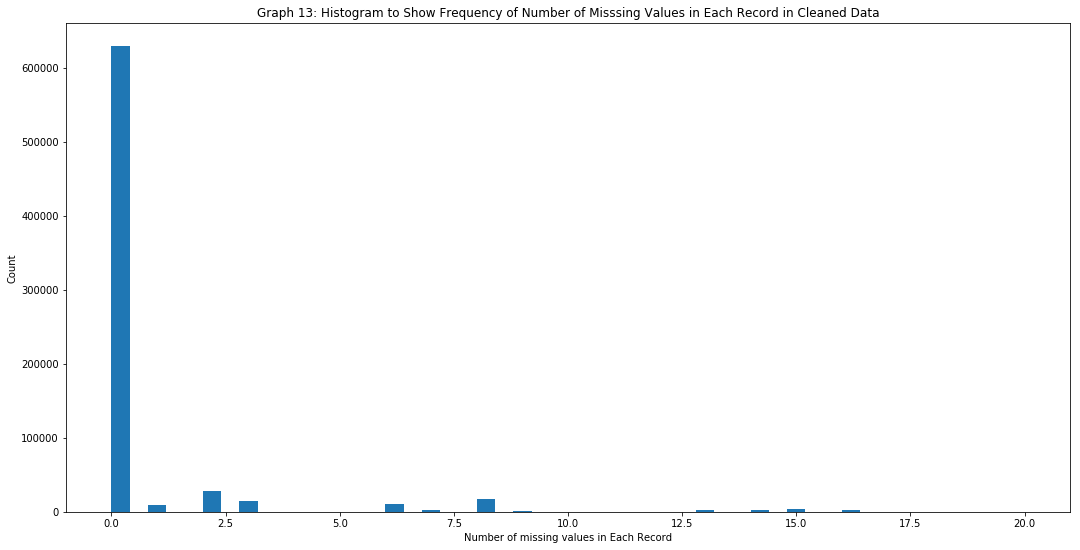

In [62]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Check how many rows have at least some missing data
missing_data_per_row = [azdias_cleaned.iloc[i].isnull().sum()for i in range(len(azdias_cleaned.index))]
print("Number of data points with no missing data: {0}, which is {1}% of the data set".format(
                                                        missing_data_per_row.count(0), 
                                                        missing_data_per_row.count(0)*100/len(azdias_cleaned.index)))

# Plot a histogram to show the distribution
plt.figure(figsize=(18, 9))
plt.hist(missing_data_per_row, bins=50)
plt.xlabel('Number of missing values in Each Record')
plt.ylabel('Count')
plt.title('Graph 13: Histogram to Show Frequency of Number of Misssing Values in Each Record in Cleaned Data')
plt.show()

This shows that about if we drop every data point that contains any missing data, then we will lose about 13% of the data set. This seems like a lot to lose, especially since we have already dropped some incomplete data points during the one-hot encoding process for some categoricals earlier on, so it is better to use an imputer here, rather than dropping. Most of the data is either ordinal or categorical, so we will apply the "most frequent" replacement strategy for the imputer across the whole data frame.

In [63]:
imp = SimpleImputer(strategy="most_frequent")
# Imputer model saved for use on customer data.
imp_model = imp.fit(azdias_cleaned)
azdias_imputed = imp_model.transform(azdias_cleaned)

In [64]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
# Scaling model saved for use on customer data.
scaling_model = scaler.fit(azdias_imputed) # Fit data
azdias_scaled = scaling_model.transform(azdias_imputed) # Transform the data

### Discussion 2.1: Apply Feature Scaling
Around 13% of the data set contains at least one missing value. Rather than just dropping this and losing information, it was decided to use an imputer with strategy "most frequent" to replace the NaN values.
A standard scaler is used to scale the data. The imputer and scaler models fitted here are saved for later use on the customer data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [65]:
# Apply PCA to the data.
pca = PCA()
pca_model = pca.fit(azdias_scaled)

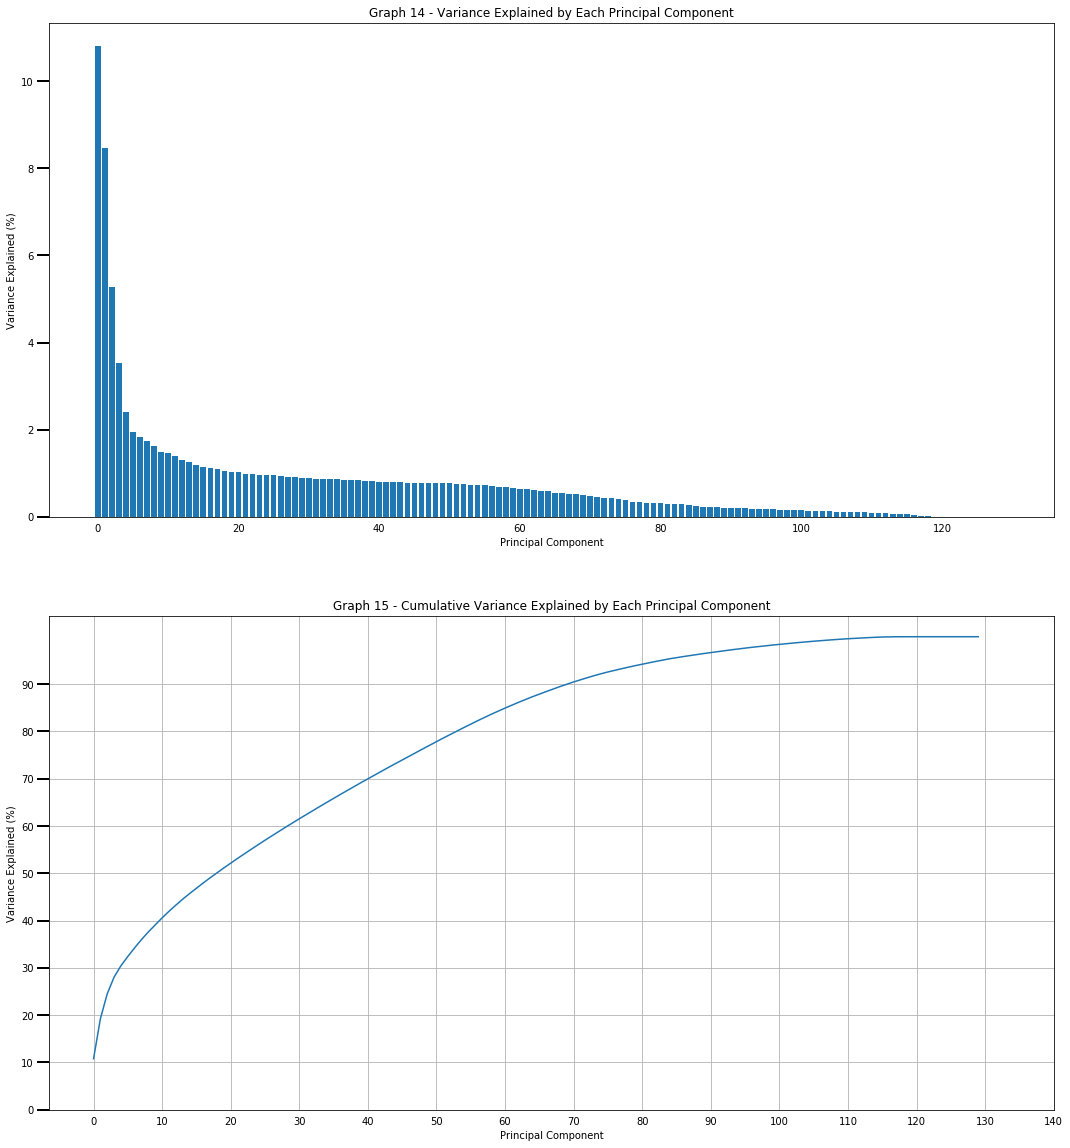

In [66]:
# Investigate the variance accounted for by each principal component.

# Calculate variance values and a cumulative total
num_components=len(pca_model.explained_variance_ratio_)
ind = np.arange(num_components)
vals = (pca_model.explained_variance_ratio_) * 100
cumvals = np.cumsum(vals)

# Plot graphs of variance value and cumulative total
fig, ax = plt.subplots(2, 1, figsize=[18,20])
ax[0].set_title('Graph 14 - Variance Explained by Each Principal Component')
ax[0].bar(ind, vals)
ax[0].xaxis.set_tick_params(width=0)
ax[0].yaxis.set_tick_params(width=2, length=12)
ax[0].set_xlabel("Principal Component")
ax[0].set_ylabel("Variance Explained (%)")

ax[1].set_title('Graph 15 - Cumulative Variance Explained by Each Principal Component')
ax[1].plot(ind, cumvals)
ax[1].xaxis.set_tick_params(width=0)
ax[1].yaxis.set_tick_params(width=2, length=12)
ax[1].grid()
ax[1].set_xlabel("Principal Component")
ax[1].set_ylabel("Variance Explained (%)")
ax[1].xaxis.set_ticks(np.arange(0, 145, 10))
ax[1].yaxis.set_ticks(np.arange(0, 100, 10))

plt.show()

Graph 15 in particular shows that 85% of the variance can be captured with 60 principal components. Therefore, the analysis will continue with 60 principal components in the PCA model.

In [67]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=60)
# Retain PCA model for later use on customer data.
pca_model = pca.fit(azdias_scaled)
azdias_pca = pca_model.transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction
Graph 15 in particular shows that 85% of the variance can be captured with 60 principal components. Therefore, the analysis will continue with 60 principal components in the PCA model.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [68]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def interpret_pc(pca, pca_num):
    pc_to_feat = pd.DataFrame(pca_model.components_, columns=azdias_cleaned.columns)
    pc = pc_to_feat.iloc[pca_num]
    print("All component weights for Principal Component {}, sorted by weight:".format(pca_num+1))
    print(pc.sort_values(ascending=False))
    print("")
    print("5 largest positive-weighted features in Principal Component {0}:".format(pca_num+1))
    print(pc.sort_values(ascending=False).iloc[0:5])
    print("")
    print("5 largest negative-weighted features in Principal Component {0}:".format(pca_num+1))
    print(pc.sort_values(ascending=False).iloc[-5:])
    
interpret_pc(pca_model, 0)

All component weights for Principal Component 1, sorted by weight:
LP_STATUS_GROB_1.0       0.197182
PLZ8_ANTG3               0.190742
PLZ8_ANTG4               0.185582
WEALTH                   0.184084
HH_EINKOMMEN_SCORE       0.183331
PLZ8_BAUMAX              0.183023
ORTSGR_KLS9              0.165187
EWDICHTE                 0.162695
FINANZ_HAUSBAUER         0.141628
FINANZ_SPARER            0.134803
KBA05_ANTG4              0.132958
PLZ8_ANTG2               0.129891
FINANZTYP_1              0.122648
KBA05_ANTG3              0.120150
ANZ_HAUSHALTE_AKTIV      0.119415
ARBEIT                   0.118966
CAMEO_DEUG_2015_9        0.114692
RELAT_AB                 0.111913
SEMIO_PFLICHT            0.101666
MOVEMENT                 0.098475
SEMIO_REL                0.097069
CAMEO_DEUG_2015_8        0.092771
DECADE                   0.092282
ZABEOTYP_5               0.088097
SEMIO_TRADV              0.087958
SEMIO_RAT                0.086067
LP_FAMILIE_GROB_1.0      0.081050
GEBAEUDETYP_3.0

#### General Interpretation
A principal component (PC) will itself be a weighted sum of the features in the data set. In general, a principal component will have some features which are positive and some which are negative. The positive features will tend to correlate with one another, and the negative features will correlate with one another. The positive and negative features will tend to anti-correlate with one another - they are in opposition to one another.

A principal component will *increase* in the positive direction (or *decrease* in the negative direction) with an *increase* in the absolute value of the *positive* features. The reverse is true for the negative features, i.e. a principal component will *decrease* in the positive direction (or *increase* in the negative direction) with an *increase* in the absolute value of the *negative* features.

Each of the first four PCs will be interpreted accordingly.

#### Interpreting First Principal Component
**Largest Positive Components**
- LP_STATUS_GROB_1.0:    0.197182 - Social status, rough scale - low earners
- PLZ8_ANTG3:            0.190742 - Number of 6-10 family houses in the PLZ8 region
- PLZ8_ANTG4:            0.185582 - Number of 10+ family houses in the PLZ8 region
- WEALTH:                0.184084 - Wealth level (Higher value indicates poorer household)
- HH_EINKOMMEN_SCORE:    0.183331 - Estimated household net income (a higher number indicates a lower income)

**Largest Negative Components**
- KBA05_ANTG1:         -0.184104 - Number of 1-2 family houses in the microcell
- KBA05_GBZ:           -0.185269 - Number of buildings in the microcell
- PLZ8_ANTG1:          -0.191666 - Number of 1-2 family houses in the PLZ8 region
- MOBI_REGIO:          -0.192477 - Movement patterns (higher number indicates lower movement)
- FINANZ_MINIMALIST:   -0.201924 - Financial typology - low financial interest (higher number=lower affinity for this type)

Principal component 1 will increase in the positive direction with:
- low earning individuals
- an increase in the number of homes rated 6-10 or above 10
- a poorer household (corresponding to higher WEALTH score)
- a lower income (corresponding to a higher HH_EINKOMMEN_SCORE)

Principal component 1 will increase in the negative direction with:
- an increase in the number of homes rated 1-2 in the regon/microcell
- an increase in the number of buildings in an area (i.e. building density)
- a lower level of movement (lower level of movement results in higher MOBI_REGIO score)
- a low affinity for a "minimalist" finacial type (low affinity gives a higher FINANZ_MINIMALIST score)

In summary, PC1 is mainly concerned with money, income and housing.
- PC1 is positive for: many homes rated above 6, poorer households, and lower income.
- PC1 is negative for: many homes rated 1-2, higher building density (cities?), lower level of movement, and not a "minimalist" financial type.

In [69]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pc(pca_model, 1)

All component weights for Principal Component 2, sorted by weight:
ALTERSKATEGORIE_GROB     0.230636
FINANZ_VORSORGER         0.210578
ZABEOTYP_3               0.203173
SEMIO_ERL                0.190223
SEMIO_LUST               0.165208
RETOURTYP_BK_S           0.154254
W_KEIT_KIND_HH           0.122612
FINANZ_HAUSBAUER         0.110667
CJT_GESAMTTYP_2.0        0.103748
FINANZTYP_5              0.094858
PLZ8_ANTG3               0.088037
PLZ8_ANTG4               0.086401
SEMIO_KRIT               0.085657
EWDICHTE                 0.084179
FINANZTYP_2              0.083856
ORTSGR_KLS9              0.083726
PLZ8_BAUMAX              0.082118
WEALTH                   0.077099
SEMIO_KAEM               0.075682
SHOPPER_TYP_3.0          0.071796
CJT_GESAMTTYP_1.0        0.068029
KBA05_ANTG4              0.067579
LP_FAMILIE_GROB_1.0      0.065257
FINANZTYP_6              0.063633
ARBEIT                   0.063588
NATIONALITAET_KZ_1.0     0.062198
GFK_URLAUBERTYP_4.0      0.061211
FINANZ_MINIMALI

#### Interpreting Second Principal Component
**Largest Positive Components**
- ALTERSKATEGORIE_GROB:    0.230636 - Estimated age based on given name analysis
- FINANZ_VORSORGER:        0.210578 - Financial typology - be prepared (higher value=lower affinity)
- ZABEOTYP_3:              0.203173 - Energy consumption typology - Fair supplied
- SEMIO_ERL:               0.190223 - Personality typology - event-oriented (higher value=lower affinity)
- SEMIO_LUST:              0.165208 - Personality typology - sensual-minded (higher value=lower affinity)

**Largest Negative Components**
- SEMIO_TRADV:             -0.206808 - Personality typology - tradional-minded (higher value=lower affinity)
- FINANZ_UNAUFFAELLIGER:   -0.210727 - Financial typology - inconspicuous (higher value=lower affinity)
- FINANZ_SPARER:           -0.216016 - Personality typology - religious (higher value=lower affinity)
- SEMIO_REL:               -0.220640 - Financial typology - money-saver (higher value=lower affinity)
- DECADE:                  -0.232363 - Decade of birth (high decade=more recent, i.e. younger)

Principal component 2 will increase in the positive direction with:
- an increase in age
- lower affinity with the "be prepared" financial type
- higher tendency for "fair supplied" energy
- lower affinity for "event-oriented" personality type
- lower affinity for "sensual-minded" personality type

Principal component 2 will increase in the negative direction with:
- a low affinity for a "tradional-minded" personality
- a low affinity for a "inconspicuous" financial type
- a low affinity for a "religious" personality
- a low affinity for a "money-saver" financial type
- a younger age

In summary, PC2 is mainly concerned with age, personality and financial attitude.
- PC2 is positive for: higher age, non-event-oriented and non-sensual-minded personality, fair-supplied energy, non-be-prepared financial type.
- PC2 is negative for: lower age, non-traditional and non-religious personality, non-inconspicuous and non-money saving financial type.

In [70]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pc(pca_model, 2)

All component weights for Principal Component 3, sorted by weight:
SEMIO_VERT               0.325322
SEMIO_FAM                0.257878
SEMIO_SOZ                0.255082
SEMIO_KULT               0.245915
FINANZTYP_5              0.138630
FINANZ_MINIMALIST        0.136536
SHOPPER_TYP_0.0          0.126562
ZABEOTYP_1               0.113793
SEMIO_REL                0.111645
RETOURTYP_BK_S           0.091333
SEMIO_MAT                0.077646
W_KEIT_KIND_HH           0.077302
FINANZ_VORSORGER         0.066116
GREEN_AVANTGARDE         0.060963
EWDICHTE                 0.052137
ORTSGR_KLS9              0.051995
SHOPPER_TYP_1.0          0.048363
ZABEOTYP_6               0.048362
PLZ8_BAUMAX              0.047035
SEMIO_LUST               0.046364
PLZ8_ANTG4               0.044449
PLZ8_ANTG3               0.043115
LP_STATUS_GROB_5.0       0.041798
ALTERSKATEGORIE_GROB     0.039994
GFK_URLAUBERTYP_4.0      0.033133
PLZ8_ANTG2               0.031172
RELAT_AB                 0.030206
ARBEIT         

#### Interpreting Third Principal Component
**Largest Positive Components**
- SEMIO_VERT:     0.325322 - Personality typology - dreamful (increasing score=lower affinity)
- SEMIO_FAM:      0.257878 - Personality typology - family-minded (increasing score=lower affinity)
- SEMIO_SOZ:      0.255082 - Personality typology - socially-minded (increasing score=lower affinity)
- SEMIO_KULT:     0.245915 - Personality typology - cultural-minded (increasing score=lower affinity)
- FINANZTYP_5:    0.138630 - Most descriptive financial type for individual - Investor

**Largest Negative Components**
- SEMIO_ERL:    -0.196043 - Personality typology - event-oriented (increasing score=lower affinity)
- SEMIO_KRIT:   -0.268743 - Personality typology - critical-minded (increasing score=lower affinity)
- SEMIO_DOM:    -0.292860 - Personality typology - dominant-minded (increasing score=lower affinity)
- SEMIO_KAEM:   -0.322107 - Personality typology - combative attitude (increasing score=lower affinity)
- ANREDE_KZ:    -0.349994 - Gender (1=male, 2=female, i.e. higher score is more likely to be female)

Principal component 3 will increase in the positive direction with:
- lower affinity for all of the following personality types:
  - dreamful
  - family-minded
  - socially-minded
  - cultural-minded
- higher tendency to be a financial investor

Principal component 3 will increase in the negative direction with:
- lower affinity for all of the following personality types:
  - event-oriented
  - critical-minded
  - dominant-minded
  - combative attitude
- female gender

In summary, PC3 is mainly concerned with gender and personality.
- PC3 is positive for: a low affinity for any of the following personality types: dreamful, family-minded, socially-minded, cultural-minded;  and financial investor.
- PC3 is negative for: female gender and a low affinity for any of the following personality types: event-oriented, critical-minded, dominant-minded, combative attitude

In [71]:
# Map weights for the fourth principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pc(pca_model, 3)

All component weights for Principal Component 4, sorted by weight:
GREEN_AVANTGARDE         0.332421
LP_STATUS_GROB_5.0       0.258335
EWDICHTE                 0.228985
ORTSGR_KLS9              0.224355
ONLINE_AFFINITAET        0.131991
ANZ_PERSONEN             0.128246
SEMIO_DOM                0.124778
CAMEO_DEUG_2015_1        0.117428
ZABEOTYP_2               0.108284
FINANZTYP_5              0.105737
LP_FAMILIE_GROB_5.0      0.099540
SEMIO_KAEM               0.098236
ZABEOTYP_1               0.097618
PLZ8_HHZ                 0.095108
PLZ8_ANTG3               0.093955
RELAT_AB                 0.089973
PLZ8_ANTG2               0.088639
OST_WEST_KZ              0.085955
PLZ8_ANTG4               0.082117
FINANZ_UNAUFFAELLIGER    0.076584
CAMEO_DEUG_2015_2        0.073942
PLZ8_BAUMAX              0.066639
ANREDE_KZ                0.066418
SHOPPER_TYP_3.0          0.066132
LP_STATUS_GROB_3.0       0.062775
KBA05_ANTG1              0.058233
LP_FAMILIE_GROB_4.0      0.056290
ARBEIT         

#### Interpreting Fourth Principal Component
**Largest Positive Components**
- GREEN_AVANTGARDE:      0.332421 - Membership in environmental sustainability as part of youth (1=member)
- LP_STATUS_GROB_5.0:    0.258335 - Top earners
- EWDICHTE:              0.228985 - Density of households per square kilometer (higher score=higher density)
- ORTSGR_KLS9:           0.224356 - Size of community (higher=larger)
- ONLINE_AFFINITAET:     0.131991 - Online affinity (higher=greater online affinity)

**Largest Negative Components**
- BALLRAUM:             -0.193202 - Distance to nearest urban center - (higher score=greater distance)
- HH_EINKOMMEN_SCORE:   -0.199587 - Estimated household net income (higher score=lower income)
- KKK:                  -0.201501 - Purchasing power in region (higher score=lower power)
- WOHNLAGE:             -0.238497 - Neighbourhood quality/rural neighborhood (higher score=lower quality/wealth or rural)
- MOVEMENT:             -0.323099 - Movement (0=avantgarde, 1=mainstream)

Principal component 4 will increase in the positive direction with:
- Membership in an environmental sustainability group
- Top earners
- Increasing density of buildings
- Increasing size of community
- High online affinity

Principal component 4 will increase in the negative direction with:
- Increasing distance to an urban centre
- Lower income
- Lower purchasing power
- Lower neighborhood quality or rural neighbourhood
- Stronger identification with mainstream movement

In summary, PC4 is mainly concerned with living area, money, and political views.
- PC4 is positive for: environmentally-aware individuals earning top money and living in cities, high tendency to be online-connected.
- PC4 is negative for: mainstream tendency, low income and purchasing power, poorer or rural neighbourhoods further away from large population centres.

### Discussion 2.3: Interpret Principal Components

See detailed analysis for each individual component above. The key summary points are copied here:
- PC1 is positive for: many homes rated above 6, poorer households, and lower income.
- PC1 is negative for: many homes rated 1-2, higher building density (cities?), lower level of movement, and not a "minimalist" financial type.
- PC2 is positive for: higher age, non-event-oriented and non-sensual-minded personality, fair-supplied energy, non-be-prepared financial type.
- PC2 is negative for: lower age, non-traditional and non-religious personality, non-inconspicuous and non-money saving financial type.
- PC3 is positive for: a low affinity for any of the following personality types: dreamful, family-minded, socially-minded, cultural-minded;  and financial investor.
- PC3 is negative for: female gender and a low affinity for any of the following personality types: event-oriented, critical-minded, dominant-minded, combative attitude
- PC4 is positive for: environmentally-aware individuals earning top money and living in cities, high tendency to be online-connected.
- PC4 is negative for: mainstream tendency, low income and purchasing power, poorer or rural neighbourhoods further away from large population centres.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [72]:
# Over a number of different cluster counts...
MAX_CLUSTERS = 20

kmeans = []
models =[]
scores = []
for clusters in range(MAX_CLUSTERS):
    # run k-means clustering on the data and...
    kmeans.append(KMeans(clusters+1))
    models.append(kmeans[clusters].fit(azdias_pca))
    # compute the average within-cluster distances.
    scores.append(np.abs(models[clusters].score(azdias_pca)))
    print("Score for K = {0} is {1}".format(clusters+1, scores[clusters]))

Score for K = 1 is 78856115.33045231
Score for K = 2 is 71224797.5647954
Score for K = 3 is 67214097.63664752
Score for K = 4 is 64710832.648136854
Score for K = 5 is 63106945.84892693
Score for K = 6 is 61792857.04965818
Score for K = 7 is 60537644.96225836
Score for K = 8 is 59547463.20987205
Score for K = 9 is 58832058.32058971
Score for K = 10 is 58208888.172140025
Score for K = 11 is 57611870.656862855
Score for K = 12 is 57070813.02461596
Score for K = 13 is 56576014.85254925
Score for K = 14 is 56049291.14664293
Score for K = 15 is 55702427.316946596
Score for K = 16 is 55062507.86778392
Score for K = 17 is 54926898.367720164
Score for K = 18 is 54254262.480598696
Score for K = 19 is 54226025.34156085
Score for K = 20 is 53277375.24522968


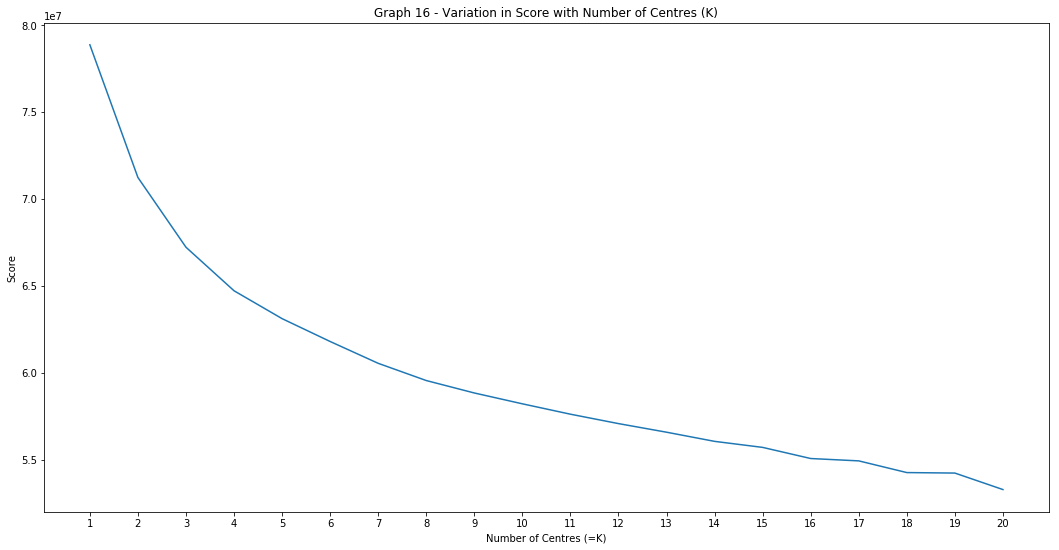

In [73]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
centres = list(range(1,MAX_CLUSTERS+1))
plt.figure(figsize=(18, 9))
plt.plot(centres, scores)
plt.title('Graph 16 - Variation in Score with Number of Centres (K)')
plt.xlabel('Number of Centres (=K)')
plt.ylabel('Score')
plt.xticks(centres)
plt.show()

In [74]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Select K=9 clusters. See discussion below for details of this choice.
# The model is already fitted and stored in the step above, just need to select it and perform the predict step.
CLUSTERS = 9
kmeans_model = models[CLUSTERS-1]
azdias_kmeans_labels = kmeans_model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Graph 16 shows that the score decreases (i.e. improves) rapidly as the number of clusters increases up to around K=7. After around K=10 the rate of improvement falls and from then on the score continues to drop in a roughly linear fashion.

Although the rate of improvement in the score falls as K increases, there is no sharp "elbow" in Graph 16, and it's possible to justify setting K between around 7 and 15.

In this analysis K=9 is chosen for the model. This is partly based on Graph 16, but also on the results of running the resulting K Means models repeatedly on a number of different K values. Some values of K can result in an unstable model, where running a re-fit on the data leads to different cluster models and therefore different interpretations. Setting K=9 and running repeatedly suggests this is a stable model that usually converges to the same solution that can be interpreted in a consistent way.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [75]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cust_cleaned, cust_high_missing_data_rows_removed = clean_data(customers)

Replaced missing data with NaN.
Dropped the following features:
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Removed 49927 rows with > 30 missing values
Re-encoded feature OST_WEST_KZ.
Dropped the following features because they contain data which overlaps/duplicates data in other features:
['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
Dropped 3124 rows due to missing data in feature CJT_GESAMTTYP
Dropped 0 rows due to missing data in feature FINANZTYP
Dropped 0 rows due to missing data in feature GFK_URLAUBERTYP
Dropped 6274 rows due to missing data in feature LP_FAMILIE_GROB
Dropped 0 rows due to missing data in feature LP_STATUS_GROB
Dropped 1860 rows due to missing data in feature NATIONALITAET_KZ
Dropped 217 rows due to missing data in feature SHOPPER_TYP
Dropped 0 rows due to missing data in feature ZABEOTYP
Dropped 0 rows due to missing data in feature GEBAEUDETYP
Dropped 466 rows due to missing data in feature CAMEO_DEUG_2015
One

Check the processed customer data:

In [76]:
cust_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,0,2.0,1,3
1,4.0,2,5,1,5,1,4,4,1,2.0,...,0,1,0,0,0,0,0,2.0,3,4
2,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,1,0,0,1,4.0,4,1
3,3.0,1,5,1,5,1,2,3,1,3.0,...,0,1,0,0,0,0,0,2.0,3,4
4,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,0,2.0,2,3


In [77]:
cust_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129784 entries, 0 to 129783
Columns: 130 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(40), int64(28), uint8(62)
memory usage: 75.0 MB


In [78]:
cust_cleaned.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
count,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000,...,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000,129784.000000
mean,3.512536,1.323907,4.287878,1.424105,4.564646,1.598695,1.858380,2.701080,0.506364,1.968941,...,0.158286,0.082005,0.131534,0.073445,0.089965,0.042694,0.487949,2.892229,2.573091,3.375501
std,0.686192,0.467967,0.998308,0.817329,0.844057,0.992276,0.969683,1.308628,0.499961,0.773013,...,0.365010,0.274374,0.337985,0.260867,0.286133,0.202167,0.499857,1.354741,1.397422,1.332070
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.000000,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,2.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000
50%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,4.000000
75%,4.000000,2.000000,5.000000,2.000000,5.000000,2.000000,2.000000,4.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,4.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,5.000000


In [79]:
#For debugging/investigation only. Run this to re-fit the model.
#CLUSTERS=9
#kmeans=KMeans(CLUSTERS)
#kmeans_model=kmeans.fit(azdias_pca)
#azdias_kmeans_labels = kmeans_model.predict(azdias_pca)

Apply imputation, scaling, dimensionality reduction and clustering on the cleaned customer data using the models created on the demographics data set:

In [80]:
# Impute for missing values using the model created on demographics data
cust_imputed = imp_model.transform(cust_cleaned)
# Apply feature scaling to the data using the model trained on the demographics data
cust_scaled = scaling_model.transform(cust_imputed)
# Apply PCA using the model created on the demographics data
cust_pca = pca_model.transform(cust_scaled)
# Apply the K-Means clustering model developed on the demographics data
cust_kmeans_labels = kmeans_model.predict(cust_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [81]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Need to account for data removed due to high missing data earlier in the analysis.
# To do this, append an additional cluster to the kmeans_labels lists for the demographic and customer data sets.

# We will not plot or analyse this "extra" cluster for rows removed due to high mising data,
# but it is worth comparing how much data was removed from the demographic and customer data sets.
print("Proportion of azdias data removed due to high missing data: {}%".format(
    high_missing_data.count(True)*100/(len(azdias_kmeans_labels)+high_missing_data.count(True))))
print("Proportion of customer data removed due to high missing data : {}%".format(
    cust_high_missing_data_rows_removed*100/(len(cust_kmeans_labels)+cust_high_missing_data_rows_removed)))

Proportion of azdias data removed due to high missing data: 11.374253653890769%
Proportion of customer data removed due to high missing data : 27.781827489691782%


It's worth noting here that the proportion of data removed from the customer data set due to high missing data is significantly higher than that removed from the demographic data set. The following analysis will partly take this into account by treating it as if it were a seperate cluster, but this cluster will have no real label in the K Means model so there is no further analysis that can be done on it. This difference is a little concerning because it may skew the results but for now there is nothing further that can be done to rectify this other than taking note and considering how this could be fixed in a future analysis.

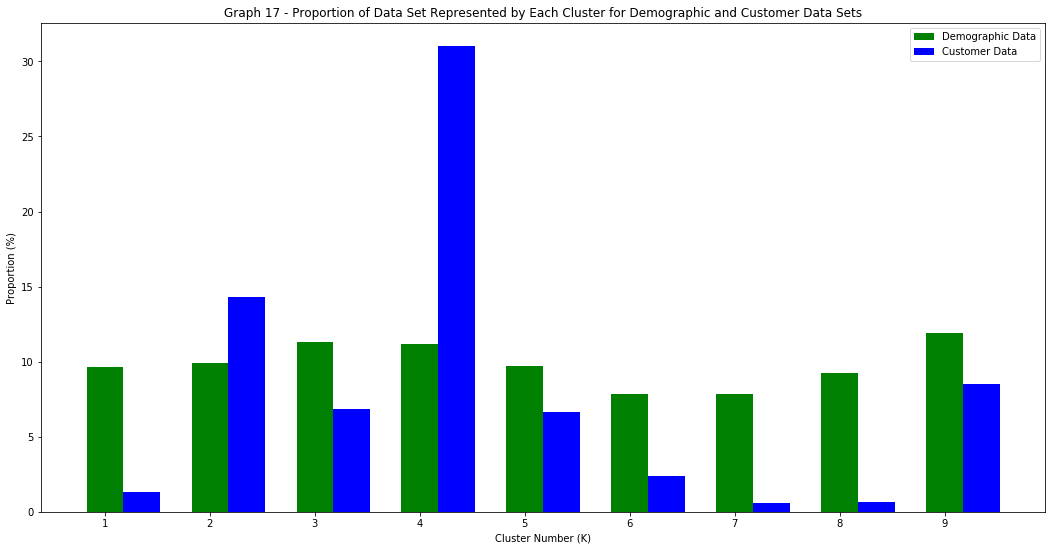

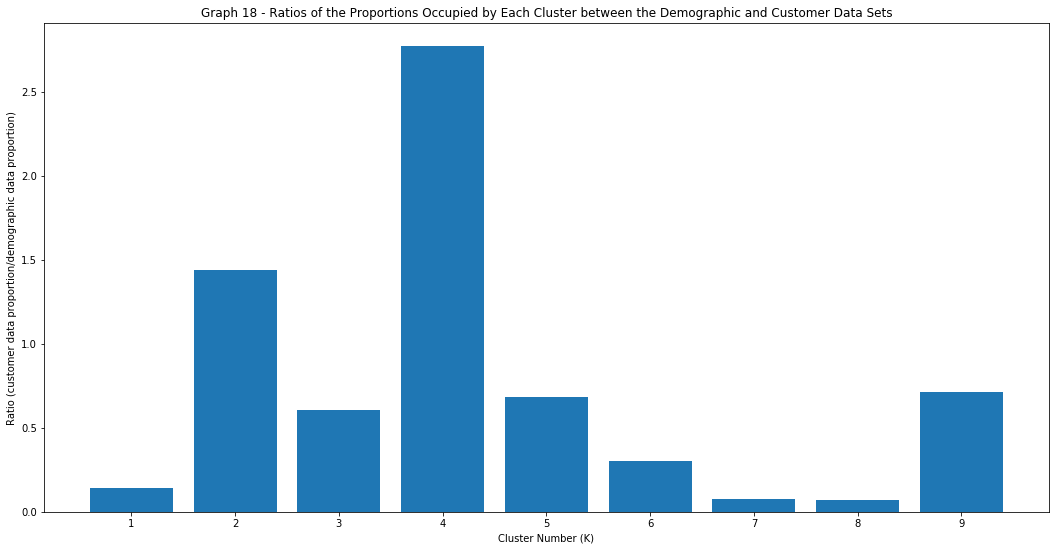

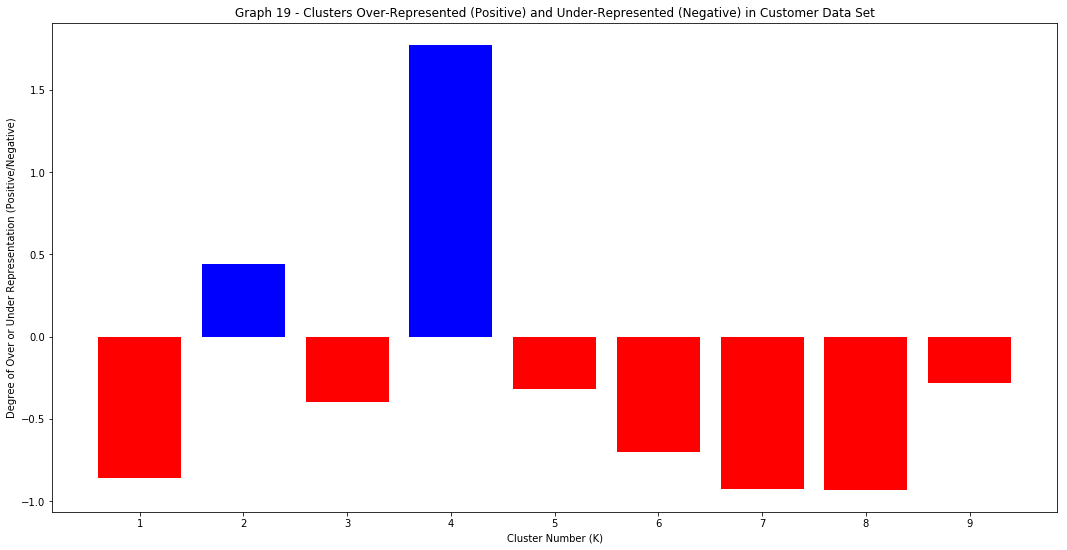

In [82]:
# Now create the "extra" cluster labels for the rows removed due to high missing data:
azdias_high_missing_data_cluster = np.ones(high_missing_data.count(True), dtype=np.int32) * CLUSTERS
azdias_kmeans_labels = np.concatenate([azdias_kmeans_labels, azdias_high_missing_data_cluster])
cust_high_missing_data_cluster = np.ones(cust_high_missing_data_rows_removed, dtype=np.int32) * CLUSTERS
cust_kmeans_labels = np.concatenate([cust_kmeans_labels, cust_high_missing_data_cluster])

# Calculate proportion proportion of the data set made up by each cluster
cust_label_count = np.bincount(cust_kmeans_labels, minlength=CLUSTERS+1)
azdias_label_count = np.bincount(azdias_kmeans_labels, minlength=CLUSTERS+1)
cust_proportion = cust_label_count / len(cust_kmeans_labels)
azdias_proportion = azdias_label_count / len(azdias_kmeans_labels)

k = np.arange(1, CLUSTERS+1)
# Plot a chart to show the proportion of each data set represented by each cluster
# Note the last cluster is the "inferred" cluster consisting of rows with high missing data
# This data was removed so this additional (last) cluster is not plotted.

fig, ax = plt.subplots(figsize=[18, 9])
width=0.35
p1 = ax.bar(k, azdias_proportion[0:-1] * 100, width, color='g')
p2 = ax.bar(k+width, cust_proportion[0:-1] * 100, width, color='b')
ax.set_title('Graph 17 - Proportion of Data Set Represented by Each Cluster for Demographic and Customer Data Sets')
ax.set_xlabel('Cluster Number (K)')
ax.set_ylabel('Proportion (%)')
ax.set_xticks(k)
ax.legend((p1[0], p2[0]), ('Demographic Data', 'Customer Data'))
ax.autoscale_view()
plt.show()

# Plot a chart to show the ratios of the proportions occupied by each cluster between the demographic and customer datasets
ratio = cust_proportion / azdias_proportion
plt.figure(figsize=(18, 9))
plt.bar(k, ratio[0:-1])
plt.title('Graph 18 - Ratios of the Proportions Occupied by Each Cluster between the Demographic and Customer Data Sets')
plt.xlabel('Cluster Number (K)')
plt.ylabel('Ratio (customer data proportion/demographic data proportion)')
plt.xticks(k)
plt.show()

# Plot a chart to show an indication of clusters which are over-represented (positive values) and under represented (negative values) in the customer data
representation = ratio-1
colormap = ['b' if representation[i] > 0 else 'r' for i in range(len(representation))]
plt.figure(figsize=(18, 9))
plt.bar(k, representation[0:-1], color=colormap)
plt.title('Graph 19 - Clusters Over-Represented (Positive) and Under-Represented (Negative) in Customer Data Set')
plt.xlabel('Cluster Number (K)')
plt.ylabel('Degree of Over or Under Representation (Positive/Negative)')
plt.xticks(k)
plt.show()


In [83]:
# Function to print out the 3 most significant principal components (by absolute value) in a cluster
def interpret_cluster(pca_model, cluster):
    cluster_pcs = pd.DataFrame(pca_model.cluster_centers_[cluster])
    print("Most Significant 3 Principal Components (by absolute value) in Cluster {0}:".format(cluster+1))
    print(cluster_pcs.reindex(cluster_pcs.abs().sort_values(0, ascending=False).index).iloc[0:3])
    print("(Principal component number given by index+1 in this table.)")

In [86]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 4 (index 3 in kmeans_model.cluster_centers_) is over represented in the customer data.
# Print details of principal components:
print(kmeans_model.cluster_centers_[3])
print("")
interpret_cluster(kmeans_model, 3)

[-4.18139943e+00  8.32824363e-01  7.61202308e-01  3.01804130e+00
 -1.55693883e-01 -3.93732010e-01 -2.49395739e-01 -2.86640809e-01
 -1.99846738e-02  2.49568341e-01 -3.56360016e-01 -5.41016616e-01
 -1.95179205e-02 -4.36948463e-01 -3.09472507e-01 -2.80914073e-01
 -1.75295967e-01  4.69502023e-01 -2.37808574e-01 -4.87107580e-02
  5.72051662e-03  1.45792212e-01 -4.13703733e-02 -5.09879346e-02
 -1.94434307e-01 -2.91860777e-01  4.64261171e-04  6.07955513e-02
  8.04089578e-02  1.28417422e-02  9.83208604e-02 -4.58208506e-02
  6.10202742e-02  2.83172400e-02 -1.85659869e-01  4.94111444e-02
 -8.31008366e-02  1.00677208e-02 -5.09938712e-02  1.17291865e-02
 -9.44730273e-02  1.67450033e-02  7.40586097e-02 -3.26817139e-02
  2.45127472e-02  1.00986972e-01 -4.97319849e-02  8.11113094e-02
 -7.39962873e-02 -5.18925432e-02  4.60638996e-02  6.33805445e-02
 -6.95615238e-02  5.52343259e-02  3.12792168e-02 -8.12871160e-02
 -5.84144302e-02  6.76688146e-02 -8.05186880e-02  8.08082606e-02]

Most Significant 3 Prin

Looking at the three principal components (PC) with the largest absolute value (descending order of importance):

- PC 1 negative
- PC 4 positive
- PC 2 positive

This can be interpreted in terms of the features represented by the principal components. A detailed summary is given here:[Discussion 2.3: Interpret Principal Components](#Discussion-2.3:-Interpret-Principal-Components)

Using this we can infer some key traits of the type of person in this cluster:
- High income
- City dweller
- Environmentally-aware
- Older

Note that PC3 is not so important in this cluster, so gender is *not* a very significant factor.

In [87]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Clusters 8 and 7 (index 7 and 6 in kmeans_model.cluster_centers_) are particularly under represented in the customer data.
# Print details of principal components for cluster 8:
print("Values of all principal components:")
print(kmeans_model.cluster_centers_[7])
print("")
interpret_cluster(kmeans_model, 7)

Values of all principal components:
[ 5.06586155e+00 -1.60615702e+00 -2.70981611e+00  5.42773323e-01
 -2.32118273e-01 -2.18874570e-01 -1.23622444e-02 -2.01599359e-01
  3.25115723e-02  4.83748850e-01  3.55559082e-01 -2.35114708e-01
  5.36418489e-01  4.67019687e-02  8.45168788e-02 -3.72685419e-01
  1.13756452e-03 -1.59377656e-01 -8.80676262e-02 -6.00830529e-02
 -1.28580867e-01  2.85769721e-01 -2.19313579e-02 -7.88783848e-02
 -7.63673880e-02 -6.77443604e-02 -3.43822023e-02  5.10588476e-02
 -9.28032096e-03  8.83083800e-03  1.78399324e-01 -4.15825007e-02
  2.21969870e-02 -5.86502302e-02 -7.41092354e-02 -5.97077764e-03
 -3.70564272e-02  5.89743675e-02 -6.96415039e-03  6.95543878e-03
  2.06421312e-02  6.58631383e-02  4.27255451e-02  3.29593585e-02
  1.79159951e-02  9.83034160e-02 -2.56614192e-02  4.25608782e-02
 -6.08225787e-02 -3.99633599e-02  4.47275367e-02  3.32109708e-02
 -6.52253221e-02  1.79153825e-02 -9.28116862e-02 -3.16650801e-02
  6.11355706e-02  6.23603614e-02 -3.71940132e-02 -1.89

Looking at the three principal components (PC) with the largest absolute value:

- PC 1 positive
- PC 3 negative
- PC 2 negative



This can be interpreted using: [Discussion 2.3: Interpret Principal Components](#Discussion-2.3:-Interpret-Principal-Components)

Some key traits of the type of person in this cluster:

- Poorer households, lower income
- Female
- Young

In [88]:
# Cluster 7 (index 6 in kmeans_model.cluster_centers_) is also under represented in the customer data.
# Print details of principal components for cluster 6:
print("Values of all principal components:")
print(kmeans_model.cluster_centers_[6])
print("")
interpret_cluster(kmeans_model, 6)

Values of all principal components:
[ 4.85152540e+00 -2.59587453e+00  2.53806098e+00 -3.82845229e-01
 -1.06496383e-01 -1.09147785e-01  1.61550430e-01 -1.70175493e-01
 -6.08908097e-01  8.18930447e-02 -4.59373437e-01  4.92877451e-02
 -2.47583571e-01 -6.86711340e-01  6.05476153e-02  2.46203538e-01
  1.41146704e-01 -1.82703180e-02  7.45301691e-02 -2.08091314e-01
 -2.05118791e-02  1.77843103e-01 -7.74914988e-02  3.87077292e-02
  4.98514378e-02 -3.25224319e-01 -5.03293343e-03 -1.22354030e-03
  1.04944186e-01 -1.28623506e-01  1.40736308e-02 -4.80054824e-02
  7.87197030e-02  1.44274490e-02  8.84083512e-02  5.45310455e-02
 -1.59844327e-01 -2.97438958e-02 -2.45653395e-02  3.60687526e-02
 -1.86928478e-02  1.14403305e-01  6.36913909e-02 -3.39214026e-02
 -6.34639910e-02  5.01049669e-02 -4.98522693e-02  4.92763447e-02
 -3.69872869e-02 -2.14532445e-02 -2.42059267e-02 -9.78179720e-03
 -2.69719411e-02  1.88010524e-02 -3.49022639e-02 -1.60764083e-01
 -1.99290075e-01  9.60130588e-02 -2.83657925e-02 -1.94

Three principal components (PC) with the largest absolute value:

- PC 1 positive
- PC 2 negative
- PC 3 positive

This is a similar set to cluster 8, but with PC3 positive and different order for the second and third components.

Using: [Discussion 2.3: Interpret Principal Components](#Discussion-2.3:-Interpret-Principal-Components)

Some key traits of the type of person in this cluster:

- Poorer households, lower income
- Male
- Young

So looking at clusters 7 and 8 together (these have a very similar level of under-representation in the customer data) we conclude that low wealth, low income and low age are important, but gender is not a distinguishing factor.

Note that PC4 is not so important in cluster 7 or 8, so environmental awareness is *not* a distinguishing feature of this group.

### Discussion 3.3: Compare Customer Data to Demographics Data
Running this model (with 60 principal components, 9 cluster centres) repeatedly on the data usually converges to a solution where there is one cluster which is particularly over-represented compared to the demographic data. This cluster would be an excellent group for the company to direct their marketing towards. The characteristics of this cluster are:

- High income
- City dweller
- Environmentally-aware
- Older

Several other clusters were found which are under-represented in the customer data compared to the demographic data. For these groups, company marketting would not be expected to be effective. One such group has the following characteristics:

- Poorer households, lower income
- Young

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.